# Term Deposit Campaign Analysis

This Jupyter Notebook documents the analysis and modeling process for a term deposit campaign dataset. The goal is to predict the number of calls needed to convert a customer based on various features.

## Table of Contents
1. [Data Preparation](#data-preparation)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Modeling](#modeling)
4. [Model Evaluation](#model-evaluation)
5. [Conclusions](#conclusions)

## Data Preparation

In this section, we will prepare the data for analysis and modeling. This involves loading the data, cleaning it, and performing any necessary transformations. The steps include:

1. **Loading the Data**: We will load the raw data from the specified path in the configuration file.
2. **Data Cleaning**: This includes handling missing values, converting data types, and encoding categorical variables.
3. **Feature Engineering**: Creating new features that may help improve the model's performance.
4. **Data Splitting**: Splitting the data into training and testing sets to evaluate the model's performance.

By the end of this section, we will have a clean and well-prepared dataset ready for modeling.

In [69]:
import os
import sys
# Change the working directory to the root of the project
while not os.path.isdir('term_deposit'):
    os.chdir("..")
print(f"{os.getcwd()}")

sys.path.append("./term_deposit")
from term_deposit.metrics import CustomRecallFunc, recall_class_1_function
from term_deposit.regression import plot_true_vs_predicted

/workspaces/2-term_deposit_marketing


In [70]:
import copy
import pickle
import multiprocessing
from pathlib import Path
from IPython.display import display, Markdown

import plotly.express as px
import matplotlib.pyplot as plt

import toml
import numpy as np
import pandas as pd

import ray
import mlflow
from flaml import AutoML
from sklearn.model_selection import train_test_split

# Load the configuration file
settings = toml.load('config.toml')

## Data Preparation

In this section, we will prepare the data for analysis and modeling. This involves loading the data, cleaning it, and performing any necessary transformations. The steps include:

1. **Loading the Data**: We will load the raw data from the specified path in the configuration file.
2. **Data Cleaning**: This includes handling missing values, converting data types, and encoding categorical variables.
3. **Feature Engineering**: Creating new features that may help improve the model's performance.
4. **Data Splitting**: Splitting the data into training and testing sets to evaluate the model's performance.

By the end of this section, we will have a clean and well-prepared dataset ready for modeling.

In [71]:
# Load the data
df = pd.read_parquet(settings['paths']["data"]['raw_pdata'])
df['y'] = df['y'].replace({'yes': 1, 'no': 0}).astype('uint8')

# Split the data
df_signup = df[df.y==1]
y = df_signup["campaign"]

# Drop the columns that are added after the first call.
X = df_signup.drop(columns=['y', "campaign", "duration"])
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2896 entries, 83 to 39997
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        2896 non-null   int64 
 1   job        2896 non-null   object
 2   marital    2896 non-null   object
 3   education  2896 non-null   object
 4   default    2896 non-null   object
 5   balance    2896 non-null   int64 
 6   housing    2896 non-null   object
 7   loan       2896 non-null   object
 8   contact    2896 non-null   object
 9   day        2896 non-null   int64 
 10  month      2896 non-null   object
dtypes: int64(3), object(8)
memory usage: 271.5+ KB


In [72]:
df_conversion_rate = df.groupby('day').agg({
    "campaign": "mean",
    "y": "mean"
    }).rename(columns={
        "campaign": "calls_needed",
        "y": "conversion_rate"}
        )

df_signup_cr = df_signup.groupby('day').agg({
    "campaign": "mean"
    }).rename(columns={
        "campaign": "calls_needed",}
        )

df_conversion_rate = df_conversion_rate.join(
    df_signup_cr, how="left",
    lsuffix="_all", rsuffix="_signup"
)

In [73]:
# Plot the percentage of signups per day of the month
percentile_75 = df_conversion_rate["conversion_rate"].quantile(0.60)
colors = ['orange' if count > percentile_75 else 'blue' for count in df_conversion_rate["conversion_rate"]]

plt.figure(figsize=(10, 6))
df_conversion_rate["conversion_rate"].plot(kind='bar', color=colors)
plt.xlabel('Day of the Month')
plt.ylabel('Percentage of Signups')
plt.title('Percentage of Signups per Day of the Month')
plt.show()

KeyboardInterrupt: 

gray      0.741935
orange    0.161290
green     0.096774
Name: conversion_rate, dtype: float64

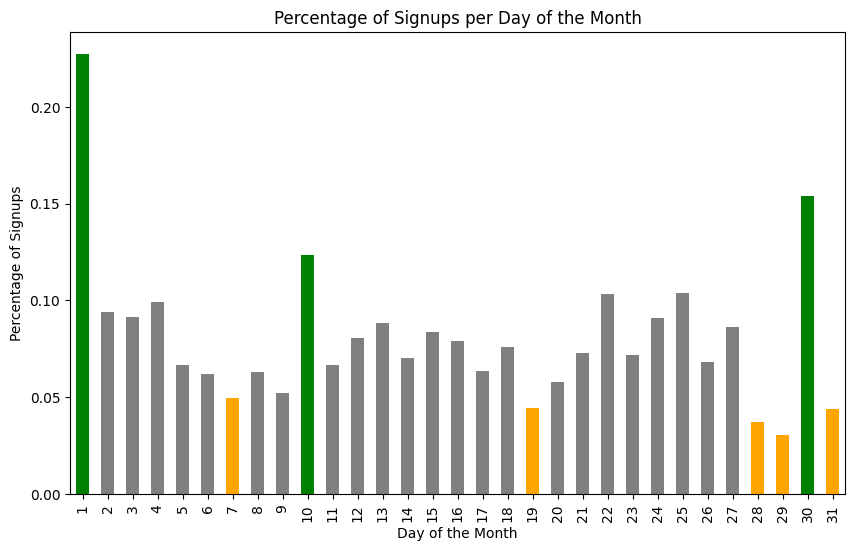

In [ ]:
# Calculate the standard deviation of the 'day' column
std_su = df_conversion_rate["conversion_rate"].std() *.8
mean_su = df_conversion_rate["conversion_rate"].mean()
day_encoded = df_conversion_rate["conversion_rate"].map(lambda x: 1 if x > (mean_su + std_su) else (-1 if x < (mean_su - std_su) else 0))

# for day encoded replace 1 with "gray", -1 with "orange" and 0 with "gray", store it as colors.
colors = day_encoded.map({1: 'green', -1: 'orange', 0: 'gray'})
display(colors.value_counts(normalize=True)) # Display the percentage of each color

# Plot the percentage of signups per day of the month
plt.figure(figsize=(10, 6))
df_conversion_rate["conversion_rate"].plot(kind='bar', color=colors)
plt.xlabel('Day of the Month')
plt.ylabel('Percentage of Signups')
plt.title('Percentage of Signups per Day of the Month')
plt.show()

In [ ]:

# Create a DataFrame for Plotly
df_plot = df_conversion_rate.reset_index()

# Normalize the columns so that the sum of each column is 1
df_plot['norm_calls_needed_all'] = df_plot["calls_needed_all"] / df_plot["calls_needed_all"].sum()
df_plot['norm_calls_needed_signup'] = df_plot["calls_needed_signup"] / df_plot["calls_needed_signup"].sum()
df_plot['norm_conversion_rate'] = df_plot['conversion_rate'] / df_plot['conversion_rate'].sum()

# Plot using Plotly Express
fig = px.bar(df_plot, x='day', y=['norm_calls_needed_all', 'norm_calls_needed_signup'], 
             title='Number of Calls Needed to Convert a Customer per Day of the Month',
             labels={'value': 'Normalized Number of Calls Needed', 'day': 'Day of the Month'},
             barmode='group', 
             color_discrete_sequence=px.colors.qualitative.Plotly)

# Add conversion rate as a line on a secondary y-axis
fig.add_scatter(x=df_plot['day'], y=df_plot['norm_conversion_rate'], mode='lines+markers', name='Conversion Rate', yaxis='y2')

# Update layout to add secondary y-axis
fig.update_layout(
    xaxis_title='Day of the Month',
    yaxis_title='Normalized Number of Calls Needed',
    yaxis2=dict(
        title='Normalized Conversion Rate',
        overlaying='y',
        side='right'
    )
)

fig.show()

In [ ]:
# Convert binary categorical columns to boolean
binary_columns = ['default', 'housing', 'loan']
X[binary_columns] = X[binary_columns].replace({'yes': 1, 'no': 0}).astype('uint8')

# Downcast the numeric columns to the smallest numerical dtype
numeric_columns = X.select_dtypes(include=[np.number]).columns
X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, downcast='unsigned')

# Convert categorical columns to category dtype
categorical_columns = ['job', 'marital', 'education', 'contact', 'month']
# X[categorical_columns] = X[categorical_columns].apply(lambda col: col.astype('category'))

X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=False)  # One-hot encode the months

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# conditions = [
#     X_train_encoded['day'].isin(df_conversion_rate['conversion_rate'].nlargest(4).index),
#     X_train_encoded['day'].isin(df_conversion_rate['conversion_rate'].nsmallest(5).index)
# ]
# choices = ['high', 'low']
# X_train_encoded['day_encoded'] = np.select(conditions, choices, default='medium')

# conditions_test = [
#     X_test_encoded['day'].isin(df_conversion_rate['conversion_rate'].nlargest(4).index),
#     X_test_encoded['day'].isin(df_conversion_rate['conversion_rate'].nsmallest(5).index)
# ]
# X_test_encoded['day_encoded'] = np.select(conditions_test, choices, default='medium')

# # if column day in dataset, drop it
# if 'day' in X_train_encoded.columns:
#     X_train_encoded.drop(columns=['day'], inplace=True)
#     X_test_encoded.drop(columns=['day'], inplace=True)

# X_train_encoded = pd.get_dummies(X_train_encoded, columns=['day_encoded'], drop_first=False)
# X_test_encoded = pd.get_dummies(X_test_encoded, columns=['day_encoded'], drop_first=False)

# Identify the top 5 days based on conversion rate
top_3_days = df_conversion_rate['conversion_rate'].nlargest(3).index

# Encode the 'day' column in X_test_encoded
X_test_encoded['day_encoded'] = X_test_encoded['day'].isin(top_3_days)

# Display the updated column
X_test_encoded['day_encoded'].head()

# Downcast boolean columns to int8
X_train_encoded[X_train_encoded.select_dtypes(include=['bool']).columns] = X_train_encoded.select_dtypes(include=['bool']).astype('int8')
X_test_encoded[X_test_encoded.select_dtypes(include=['bool']).columns] = X_test_encoded.select_dtypes(include=['bool']).astype('int8')

# Display the updated data types
# X_train.dtypes
X_train_encoded.dtypes

age                    uint8
default                uint8
balance                int64
housing                uint8
loan                   uint8
day                    uint8
job_admin              uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
contact_cellular       uint8
contact_telephone      uint8
contact_unknown        uint8
month_apr              uint8
month_aug              uint8
month_dec              uint8
month_feb              uint8
month_jan              uint8
month_jul              uint8
month_jun     

## Base model

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Add a constant term for the intercept
X_train_encoded = sm.add_constant(X_train_encoded)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train_encoded).fit()

# Print the summary of the model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               campaign   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     11.13
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           1.27e-54
Time:                        21:10:20   Log-Likelihood:                -5033.5
No. Observations:                2316   AIC:                         1.014e+04
Df Residuals:                    2281   BIC:                         1.034e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8555    

### **Conclusions from OLS-model**

1. **Effectiveness of Predictors**:
   - Certain variables like marital status, education level, contact method, and month of contact significantly affect the number of calls needed.
   - Contacting customers via cellular phones may require fewer calls, possibly due to higher accessibility.
2. **Model Limitations**:
   - Low R-squared value indicates that the model doesn't explain a large portion of the variability.
   - Non-normality of residuals suggests that OLS assumptions may not be fully met, potentially affecting the reliability of the confidence intervals and p-values.
3. **Recommendations**:
   - **Include Additional Variables**: Consider adding other relevant predictors to improve the model's explanatory power.
   - **Transformations**: Apply transformations to address skewness and kurtosis (e.g., log transformation of the dependent variable).
   - **Robust Regression**: Use regression techniques robust to violations of OLS assumptions, such as Quantile Regression or Generalized Linear Models.
4. **Practical Implications**:
   - **Targeting Strategy**: Focus on months like August and July when more calls are typically required, possibly adjusting campaign strategies during these periods.
   - **Contact Method**: Prioritize cellular contact methods to potentially reduce the number of calls needed.
   - **Customer Segmentation**: Pay attention to marital status and education level when planning call campaigns, as these groups may require more effort to reach.

### Refinement

1. Model Refinement: Remove Non-Significant Variables
2. Interaction Effects: Add Suggested Interaction Terms
3. Implementing Poisson Regression

## Implementing Poisson Regression

### **Step 1: Import Necessary Libraries**

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

### **Step 2: Combine `y_train` and `X_train_encoded`**

First, ensure that `y_train` (dependent variable) and `X_train_encoded` (independent variables) are combined into a single DataFrame for easier formula-based modeling.

In [ ]:
# Combine y_train and X_train_encoded
data_train = pd.concat([y_train, X_train_encoded], axis=1)
data_train.columns = ['campaign'] + list(X_train_encoded.columns)

data_test = pd.concat([y_test, X_test_encoded], axis=1)
data_test.columns = ['campaign'] + list(X_test_encoded.columns)

### **Step 3: Add Interaction Terms**

Add interaction terms by creating new columns in `data_train`. Use the specific interaction effects we discussed:

**Suggested Interaction Terms**:

1. **Contact Method and Month of Contact**: `contact_method * month`
2. **Marital Status and Education Level**: `marital_status * education_level`
3. **Age and Contact Method**: `age * contact_method`
4. **Job Category and Month**: `job_category * month`
5. **Housing Loan Status and Balance**: `housing_loan * balance`
6. **Default Status and Loan Status**: `default * loan`
7. **Education Level and Age**: `education_level * age`
8. **Marital Status and Job Category**: `marital_status * job_category`
9. **Contact Method and Day Encoded**: `contact_method * day_encoded`
10. **Month and Day Encoded**: `month * day_encoded`

In [ ]:
from term_deposit.causal_analysis import create_interaction_terms

# Define the interaction terms
interaction_terms = [
    'contact_cellular*day',
    'contact_cellular*month_aug',
    'marital_married*education_primary',
    'job_blue-collar*month_jul',
    'housing*balance',
    'default*loan',
    'education_tertiary*age',
    'marital_married*job_blue-collar'
]

# Create the interaction terms
data_train = create_interaction_terms(data_train, interaction_terms)
data_test = create_interaction_terms(data_test, interaction_terms)

### **Step 4: Remove Non-Significant Variables**

Based on previous OLS regression results, identify and remove non-significant variables. Here’s an example where we’ll remove some assumed non-significant variables (replace these with your actual list of non-significant variables):

In [ ]:
# Dropping non-significant variables from previous OLS model
non_significant_vars = ['age', 'default', 'balance', 'loan', 'job_technician', 'job_student']
data_train = data_train.drop(columns=non_significant_vars)
data_test = data_test.drop(columns=non_significant_vars)

### **Step 5: Define the Formula**

Construct the formula for Poisson regression by specifying `campaign` as the dependent variable and listing the predictors, including interaction terms. Example formula:

In [ ]:
formula = '''
campaign ~ marital_married + education_primary + education_secondary + contact_cellular 
+ month_aug + day
'''

### **Step 6: Fit the Poisson Regression Model**

Use the `GLM` function in `statsmodels` with the Poisson family to fit the model.

In [ ]:
# Fit Poisson regression model
model = smf.glm(formula=formula, data=data_train, family=sm.families.Poisson()).fit()

# View the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               campaign   No. Observations:                 2316
Model:                            GLM   Df Residuals:                     2309
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4499.3
Date:                Sun, 10 Nov 2024   Deviance:                       3051.4
Time:                        21:10:20   Pearson chi2:                 4.53e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1127
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7825    

Negative Binomial Regression:

Overdispersion is present, we will switch to Negative Binomial regression, which adds a parameter to model the extra variance.

#### 6. Interpreting the Results

Coefficients:

Positive Coefficient: Indicates that as the predictor increases, the expected number of calls increases.
Negative Coefficient: Indicates a decrease in the expected number of calls with an increase in the predictor.

### 7. Model Diagnostics

#### **a. Check for Overdispersion**

Calculate the dispersion parameter to see if overdispersion is an issue. Overdispersion is indicated if this parameter is significantly greater than 1.

> If `dispersion > 1`, consider using a Negative Binomial model.

In [ ]:
# Calculate dispersion
deviance = model.deviance
df_residual = model.df_resid
dispersion = deviance / df_residual

print(f"Dispersion Parameter: {dispersion:.2f}")

Dispersion Parameter: 1.32


### **Step 8: Implementing Negative Binomial Regression (Since we have Overdispersion)**

If overdispersion is present, fit a Negative Binomial regression as follows:

In [ ]:
# Negative Binomial regression
model_nb = smf.glm(formula=formula, data=data_train, family=sm.families.NegativeBinomial()).fit()

# View summary
print(model_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               campaign   No. Observations:                 2316
Model:                            GLM   Df Residuals:                     2309
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4750.9
Date:                Sun, 10 Nov 2024   Deviance:                       771.95
Time:                        21:10:20   Pearson chi2:                 1.32e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03140
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8113    

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.



In [ ]:
# Calculate dispersion for the negative binomial model
neg_binom_deviance = model_nb.deviance
neg_binom_df_residual = model_nb.df_resid
neg_binom_dispersion = neg_binom_deviance / neg_binom_df_residual

print(f"Negative Binomial Dispersion Parameter: {neg_binom_dispersion:.2f}")

Negative Binomial Dispersion Parameter: 0.33



**Considerations**:

- **Multicollinearity**: Adding interaction terms can increase multicollinearity. Check Variance Inflation Factor (VIF) values and address if necessary.
- **Model Complexity**: Balance the addition of interaction terms with model simplicity to avoid overfitting.

#### **b. Interpret Coefficients**

To interpret the model, you can exponentiate the coefficients to get the Incident Rate Ratios (IRRs):

In [ ]:
# Incident Rate Ratios (IRR)
IRR = np.exp(model_nb.params)
print(IRR)

Intercept              2.250930
marital_married        1.037761
education_primary      1.061182
education_secondary    1.024263
contact_cellular       0.798832
month_aug              1.813563
day                    1.008074
dtype: float64


Each IRR tells you the multiplicative effect of a one-unit increase in the predictor on the expected count of `campaign`.

**Address Multicollinearity**:

- **Remove or Combine Variables**: If variables are highly correlated, consider removing one or combining them.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting relevant features
features = list(model_nb.params.index)

# Calculating VIF
VIF_data = pd.DataFrame()
VIF_data['feature'] = features
VIF_data['VIF'] = [variance_inflation_factor(data_train, i)
                   for i in range(len(features))
                   ]

print(VIF_data)


               feature       VIF
0            Intercept  1.166623
1      marital_married  0.000000
2    education_primary  1.519915
3  education_secondary  5.197373
4     contact_cellular  1.476532
5            month_aug  3.879805
6                  day  1.180886


/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in double_scalars



In [ ]:
# Example: Dropping one of the correlated variables
cols_high_correlation=['month_dec','month_mar', 'education_unknown','day_encoded_low', 'marital_divorced']
# data_train = data_train.drop(columns=cols_high_correlation)
# data_test = data_test.drop(columns=cols_high_correlation)

# Reasses interaction terms
formula = """campaign ~ marital_married + education_primary
+ education_secondary + contact_cellular + month_aug + day
"""

In [ ]:
model_full = smf.glm(formula=formula, data=data_train, family=sm.families.NegativeBinomial()).fit()
print(model_full.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               campaign   No. Observations:                 2316
Model:                            GLM   Df Residuals:                     2309
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4750.9
Date:                Sun, 10 Nov 2024   Deviance:                       771.95
Time:                        21:10:21   Pearson chi2:                 1.32e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03140
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8113    

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.



Make Predictions on Test Data:

In [ ]:
# Add a constant to test data if required
# X_test = sm.add_constant(X_test, has_constant='add')

# Predict
y_pred = model_full.predict(data_test)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.999791792349767
Mean Absolute Error: 1.346720660884705


# Training

### Machine learning approach

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, data_train.drop(columns=['campaign']), y_train, cv=5, scoring='neg_mean_poisson_deviance')

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_scores = cross_val_score(gb_model, data_train.drop(columns=['campaign']), y_train, cv=5, scoring='neg_mean_poisson_deviance')

print("Random Forest Mean Poisson Deviance:", -rf_scores.mean())
print("Gradient Boosting Mean Poisson Deviance:", -gb_scores.mean())

Random Forest Mean Poisson Deviance: 1.303143274150832
Gradient Boosting Mean Poisson Deviance: 1.1618880513919967


### AutoML

In [ ]:
# Extract the directory from the log file path
log_file_path = Path(settings["automl"]['log_file_name'])
log_dir = log_file_path.parent

# Create the directory if it doesn't exist
log_dir.mkdir(parents=True, exist_ok=True)

print(f"Log directory ensured: {log_dir}")

In [ ]:
settings["automl"]['max_iter'] = 10

In [ ]:
import mlflow
from hyperopt import fmin, tpe, Trials, hp
from hyperopt.pyll.base import scope

# Define the search space for Hyperopt
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
}

# Create a Trials object to store information about the optimization process
trials = Trials()

# Ensure the correct experiment is set
mlflow.set_tracking_uri(mlflow_tracking_uri)
experiment_name = "Your_Experiment_Name"  # Replace with your experiment name

# Set the experiment, creating it if it doesn't exist
mlflow.set_experiment(experiment_name)

# Start the MLflow run
with mlflow.start_run() as run:
    run_id = run.info.run_id

    # Run Hyperopt
    best = fmin(
        fn=ut.objective,  # Objective function
        space=space,  # Search space
        algo=tpe.suggest,  # Tree-structured Parzen Estimator
        max_evals=50,  # Number of evaluations
        trials=trials  # Store results of each evaluation
    )

    print("Best parameters found:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: name 'RandomForestClassifier' is not defined



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


NameError: name 'RandomForestClassifier' is not defined

In [78]:
# Initialize an AutoML instance
automl = AutoML()

# Dynamically get the number of available CPU cores
num_cpus = multiprocessing.cpu_count()

# Log model info to MLflow in the main process
mlflow.set_experiment("flaml_parallel_experiment")
with mlflow.start_run():
    automl = AutoML()
    automl.fit(X_train, y_train, **settings["automl"])

try:
    # Ensure the directory exists
    model_dir = Path("models/flaml")
    model_dir.mkdir(parents=True, exist_ok=True)
    
    # Save the model
    with open(model_dir / "automl.pkl", "wb") as f:
        pickle.dump(automl, f)
except Exception as e:
    print("We could not save the model")
    print(e)

Traceback (most recent call last):
  File "/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
  File "/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 309, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlf

[flaml.automl.logger: 11-10 22:01:30] {1728} INFO - task = classification
[flaml.automl.logger: 11-10 22:01:30] {1739} INFO - Evaluation method: cv


INFO:flaml.automl.task.generic_task:class 8 augmented from 13 to 26
INFO:flaml.automl.task.generic_task:class 9 augmented from 9 to 27
INFO:flaml.automl.task.generic_task:class 10 augmented from 10 to 20
INFO:flaml.automl.task.generic_task:class 11 augmented from 3 to 21
INFO:flaml.automl.task.generic_task:class 12 augmented from 4 to 20
INFO:flaml.automl.task.generic_task:class 13 augmented from 3 to 21
INFO:flaml.automl.task.generic_task:class 14 augmented from 4 to 20
INFO:flaml.automl.task.generic_task:class 15 augmented from 2 to 20
INFO:flaml.automl.task.generic_task:class 16 augmented from 6 to 24
INFO:flaml.automl.task.generic_task:class 17 augmented from 1 to 20
INFO:flaml.automl.task.generic_task:class 18 augmented from 1 to 20
INFO:flaml.automl.task.generic_task:class 19 augmented from 1 to 20
INFO:flaml.automl.task.generic_task:class 20 augmented from 1 to 20


[flaml.automl.logger: 11-10 22:13:01] {1838} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 11-10 22:13:01] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.


/opt/conda/envs/term_deposit/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

INFO:flaml.default.suggest:metafeature distance: 1.9077270539081028
INFO:flaml.default.suggest:metafeature distance: 1.9077270539081028
INFO:flaml.default.suggest:metafeature distance: 1.9075095073126909
INFO:flaml.default.suggest:metafeature di

[flaml.automl.logger: 11-10 22:13:01] {1955} INFO - List of ML learners in AutoML Run: ['xgb_limitdepth', 'lgbm', 'rf', 'xgboost', 'extra_tree', 'sgd', 'lrl1']
[flaml.automl.logger: 11-10 22:13:01] {2258} INFO - iteration 0, current learner xgb_limitdepth
[flaml.automl.logger: 11-10 22:14:48] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 11-10 22:14:49] {2442} INFO -  at 797.7s,	estimator xgb_limitdepth's best error=1.4097,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:14:49] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-10 22:35:56] {2442} INFO -  at 2065.0s,	estimator lgbm's best error=2.7591,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:35:56] {2258} INFO - iteration 2, current learner rf


/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



[flaml.automl.logger: 11-10 22:37:38] {2442} INFO -  at 2166.4s,	estimator rf's best error=1.4976,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:37:38] {2258} INFO - iteration 3, current learner xgboost
[flaml.automl.logger: 11-10 22:38:06] {2442} INFO -  at 2194.4s,	estimator xgboost's best error=1.4496,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:38:06] {2258} INFO - iteration 4, current learner extra_tree


/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



[flaml.automl.logger: 11-10 22:40:16] {2442} INFO -  at 2324.5s,	estimator extra_tree's best error=1.9476,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:40:16] {2258} INFO - iteration 5, current learner sgd


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

[flaml.automl.logger: 11-10 22:40:18] {2442} INFO -  at 2326.4s,	estimator sgd's best error=2.9334,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:40:18] {2258} INFO - iteration 6, current learner lrl1


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



[flaml.automl.logger: 11-10 22:40:23] {2442} INFO -  at 2331.1s,	estimator lrl1's best error=2.5665,	best estimator xgb_limitdepth's best error=1.4097
[flaml.automl.logger: 11-10 22:40:24] {521} INFO - logging best model xgb_limitdepth
[flaml.automl.logger: 11-10 22:40:48] {2685} INFO - retrain xgb_limitdepth for 22.7s
[flaml.automl.logger: 11-10 22:40:49] {2688} INFO - retrained model: XGBClassifier(colsample_bylevel=1.0, colsample_bytree=0.2219038021462818,
              learning_rate=0.03453775119035777,
              min_child_weight=0.0010034151843327725, n_estimators=1799,
              n_jobs=-1, objective='multi:softprob',
              reg_alpha=0.03885163786709896, reg_lambda=1.1077175359756786,
              subsample=0.31322065037892344, use_label_encoder=False,
              verbosity=0)
[flaml.automl.logger: 11-10 22:40:49] {2690} INFO - Best MLflow run name: mysterious-moose-120_child_0
[flaml.automl.logger: 11-10 22:40:49] {2691} INFO - Best MLflow run id: f559f46c56044

PermissionError: [Errno 13] Permission denied: '/c:'

## Analysis

In [ ]:
# Make predictions using the best model
y_predict = automl.predict(X_test)

# Plot the true vs predicted values
plot_true_vs_predicted(
    y_test, np.round(y_predict),
    title="AutoML Model: True vs Predicted"
)

c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\flaml\data.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<BarContainer object of 11 artists>

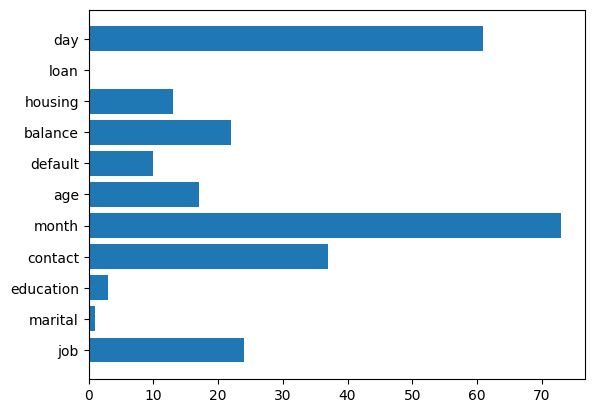

In [ ]:
plt.barh(
    automl.model.feature_name_, automl.model.feature_importances_
)

### Train encoded

In [ ]:
# Dynamically get the number of available CPU cores
num_cpus = multiprocessing.cpu_count()

# Log model info to MLflow in the main process
mlflow.set_experiment("flaml_parallel_experiment")
with mlflow.start_run():
    automl_e = AutoML()
    automl_e.fit(X_train_encoded.drop(columns='const'), y_train, **settings["automl"])

try:
    # Save the model
    with open("automl.pkl", "wb") as f:
        pickle.dump(automl, f)
except Exception as e:
    print("We could not save the model")
    print(e)

Traceback (most recent call last):
  File "c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\Guill\miniconda3\envs\term_deposit\lib\site-packages\mlflow\utils\file_utils.py", line 309, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' d

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:27:39] {787} INFO -  at 0.3s,	best lgbm's error=0.8696,	best lgbm's error=0.8696
INFO:flaml.automl: at 0.3s,	best lgbm's error=0.8696,	best lgbm's error=0.8696
[flaml.automl: 11-07 23:27:39] {728} INFO - iteration 2  current learner lgbm
INFO:flaml.automl:iteration 2  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:27:39] {787} INFO -  at 0.6s,	best lgbm's error=0.8658,	best lgbm's error=0.8658
INFO:flaml.automl: at 0.6s,	best lgbm's error=0.8658,	best lgbm's error=0.8658
[flaml.automl: 11-07 23:27:39] {728} INFO - iteration 3  current learner xgboost
INFO:flaml.automl:iteration 3  current learner xgboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:27:39] {787} INFO -  at 0.8s,	best xgboost's error=0.9402,	best lgbm's error=0.8658
INFO:flaml.automl: at 0.8s,	best xgboost's error=0.9402,	best lgbm's error=0.8658
[flaml.automl: 11-07 23:27:39] {728} INFO - iteration 4  current learner extra_tree
INFO:flaml.automl:iteration 4  current learner extra_tree
[flaml.automl: 11-07 23:27:40] {787} INFO -  at 1.3s,	best extra_tree's error=1.2139,	best lgbm's error=0.8658
INFO:flaml.automl: at 1.3s,	best extra_tree's error=1.2139,	best lgbm's error=0.8658
[flaml.automl: 11-07 23:27:40] {728} INFO - iteration 5  current learner lgbm
INFO:flaml.automl:iteration 5  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:40] {787} INFO -  at 1.6s,	best lgbm's error=0.8510,	best lgbm's error=0.8510
INFO:flaml.automl: at 1.6s,	best lgbm's error=0.8510,	best lgbm's error=0.8510
[flaml.automl: 11-07 23:27:40] {728} INFO - iteration 6  current learner xgboost
INFO:flaml.automl:iteration 6  current learner xgboost
[flaml.automl: 11-07 23:27:41] {787} INFO -  at 2.2s,	best xgboost's error=0.9076,	best lgbm's error=0.8510
INFO:flaml.automl: at 2.2s,	best xgboost's error=0.9076,	best lgbm's error=0.8510
[flaml.automl: 11-07 23:27:41] {728} INFO - iteration 7  current learner lgbm
INFO:flaml.automl:iteration 7  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:41] {787} INFO -  at 2.5s,	best lgbm's error=0.8510,	best lgbm's error=0.8510
INFO:flaml.automl: at 2.5s,	best lgbm's error=0.8510,	best lgbm's error=0.8510
[flaml.automl: 11-07 23:27:41] {728} INFO - iteration 8  current learner rf
INFO:flaml.automl:iteration 8  current learner rf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:27:41] {787} INFO -  at 3.0s,	best rf's error=1.2274,	best lgbm's error=0.8510
INFO:flaml.automl: at 3.0s,	best rf's error=1.2274,	best lgbm's error=0.8510
[flaml.automl: 11-07 23:27:41] {728} INFO - iteration 9  current learner lgbm
INFO:flaml.automl:iteration 9  current learner lgbm
[flaml.automl: 11-07 23:27:42] {787} INFO -  at 3.2s,	best lgbm's error=0.8439,	best lgbm's error=0.8439


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 3.2s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:42] {728} INFO - iteration 10  current learner extra_tree
INFO:flaml.automl:iteration 10  current learner extra_tree
[flaml.automl: 11-07 23:27:42] {787} INFO -  at 3.7s,	best extra_tree's error=1.1005,	best lgbm's error=0.8439
INFO:flaml.automl: at 3.7s,	best extra_tree's error=1.1005,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:42] {728} INFO - iteration 11  current learner lgbm
INFO:flaml.automl:iteration 11  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:27:42] {787} INFO -  at 4.1s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 4.1s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:42] {728} INFO - iteration 12  current learner lgbm
INFO:flaml.automl:iteration 12  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:43] {787} INFO -  at 4.5s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 4.5s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:43] {728} INFO - iteration 13  current learner lgbm
INFO:flaml.automl:iteration 13  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:27:43] {787} INFO -  at 5.0s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 5.0s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:43] {728} INFO - iteration 14  current learner rf
INFO:flaml.automl:iteration 14  current learner rf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:27:44] {787} INFO -  at 5.6s,	best rf's error=1.0415,	best lgbm's error=0.8439
INFO:flaml.automl: at 5.6s,	best rf's error=1.0415,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:44] {728} INFO - iteration 15  current learner extra_tree
INFO:flaml.automl:iteration 15  current learner extra_tree
[flaml.automl: 11-07 23:27:45] {787} INFO -  at 6.2s,	best extra_tree's error=1.0510,	best lgbm's error=0.8439
INFO:flaml.automl: at 6.2s,	best extra_tree's error=1.0510,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:45] {728} INFO - iteration 16  current learner lgbm
INFO:flaml.automl:iteration 16  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:45] {787} INFO -  at 6.6s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 6.6s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:45] {728} INFO - iteration 17  current learner xgboost
INFO:flaml.automl:iteration 17  current learner xgboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:27:46] {787} INFO -  at 7.2s,	best xgboost's error=0.8749,	best lgbm's error=0.8439
INFO:flaml.automl: at 7.2s,	best xgboost's error=0.8749,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:46] {728} INFO - iteration 18  current learner lgbm
INFO:flaml.automl:iteration 18  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:27:46] {787} INFO -  at 7.5s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 7.5s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:46] {728} INFO - iteration 19  current learner xgboost
INFO:flaml.automl:iteration 19  current learner xgboost


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:46] {787} INFO -  at 8.1s,	best xgboost's error=0.8749,	best lgbm's error=0.8439
INFO:flaml.automl: at 8.1s,	best xgboost's error=0.8749,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:46] {728} INFO - iteration 20  current learner rf
INFO:flaml.automl:iteration 20  current learner rf
[flaml.automl: 11-07 23:27:47] {787} INFO -  at 8.6s,	best rf's error=1.0067,	best lgbm's error=0.8439
INFO:flaml.automl: at 8.6s,	best rf's error=1.0067,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:47] {728} INFO - iteration 21  current learner lgbm
INFO:flaml.automl:iteration 21  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:47] {787} INFO -  at 9.0s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
INFO:flaml.automl: at 9.0s,	best lgbm's error=0.8439,	best lgbm's error=0.8439
[flaml.automl: 11-07 23:27:47] {728} INFO - iteration 22  current learner lgbm
INFO:flaml.automl:iteration 22  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:48] {787} INFO -  at 9.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 9.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:48] {728} INFO - iteration 23  current learner lgbm
INFO:flaml.automl:iteration 23  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 2316, number of used features: 37
[LightGBM] [Info] Start training from score 2.421848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:48] {787} INFO -  at 9.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 9.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:48] {728} INFO - iteration 24  current learner lgbm
INFO:flaml.automl:iteration 24  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:27:48] {787} INFO -  at 10.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 10.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:48] {728} INFO - iteration 25  current learner lgbm
INFO:flaml.automl:iteration 25  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:49] {787} INFO -  at 10.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 10.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:49] {728} INFO - iteration 26  current learner lgbm
INFO:flaml.automl:iteration 26  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:27:49] {787} INFO -  at 10.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 10.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:49] {728} INFO - iteration 27  current learner lgbm
INFO:flaml.automl:iteration 27  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410

[flaml.automl: 11-07 23:27:50] {787} INFO -  at 11.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 11.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:50] {728} INFO - iteration 28  current learner xgboost
INFO:flaml.automl:iteration 28  current learner xgboost


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:27:50] {787} INFO -  at 11.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
INFO:flaml.automl: at 11.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:50] {728} INFO - iteration 29  current learner lgbm
INFO:flaml.automl:iteration 29  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:51] {787} INFO -  at 12.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 12.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:51] {728} INFO - iteration 30  current learner lgbm
INFO:flaml.automl:iteration 30  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:27:51] {787} INFO -  at 12.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 12.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:51] {728} INFO - iteration 31  current learner xgboost
INFO:flaml.automl:iteration 31  current learner xgboost
[flaml.automl: 11-07 23:27:52] {787} INFO -  at 13.5s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
INFO:flaml.automl: at 13.5s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:52] {728} INFO - iteration 32  current learner lgbm
INFO:flaml.automl:iteration 32  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:27:53] {787} INFO -  at 14.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 14.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:53] {728} INFO - iteration 33  current learner lgbm
INFO:flaml.automl:iteration 33  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:27:53] {787} INFO -  at 14.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 14.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:53] {728} INFO - iteration 34  current learner lgbm
INFO:flaml.automl:iteration 34  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:53] {787} INFO -  at 15.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 15.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:54] {728} INFO - iteration 35  current learner xgboost
INFO:flaml.automl:iteration 35  current learner xgboost
[flaml.automl: 11-07 23:27:54] {787} INFO -  at 15.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
INFO:flaml.automl: at 15.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:54] {728} INFO - iteration 36  current learner lgbm
INFO:flaml.automl:iteration 36  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:27:55] {787} INFO -  at 16.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 16.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:55] {728} INFO - iteration 37  current learner extra_tree
INFO:flaml.automl:iteration 37  current learner extra_tree


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:27:55] {787} INFO -  at 16.8s,	best extra_tree's error=1.0119,	best lgbm's error=0.8422
INFO:flaml.automl: at 16.8s,	best extra_tree's error=1.0119,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:55] {728} INFO - iteration 38  current learner lgbm
INFO:flaml.automl:iteration 38  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:27:56] {787} INFO -  at 17.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 17.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:56] {728} INFO - iteration 39  current learner lgbm
INFO:flaml.automl:iteration 39  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:27:56] {787} INFO -  at 17.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 17.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:56] {728} INFO - iteration 40  current learner lgbm
INFO:flaml.automl:iteration 40  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:27:57] {787} INFO -  at 18.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 18.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:57] {728} INFO - iteration 41  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

INFO:flaml.automl:iteration 41  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:57] {787} INFO -  at 18.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 18.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:57] {728} INFO - iteration 42  current learner lgbm
INFO:flaml.automl:iteration 42  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:58] {787} INFO -  at 19.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 19.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:58] {728} INFO - iteration 43  current learner lgbm
INFO:flaml.automl:iteration 43  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:27:58] {787} INFO -  at 19.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 19.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:58] {728} INFO - iteration 44  current learner lgbm
INFO:flaml.automl:iteration 44  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:27:59] {787} INFO -  at 20.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 20.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:59] {728} INFO - iteration 45  current learner lgbm
INFO:flaml.automl:iteration 45  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:27:59] {787} INFO -  at 20.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 20.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:27:59] {728} INFO - iteration 46  current learner lgbm
INFO:flaml.automl:iteration 46  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:00] {787} INFO -  at 21.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 21.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:00] {728} INFO - iteration 47  current learner lgbm
INFO:flaml.automl:iteration 47  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:00] {787} INFO -  at 21.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 21.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:00] {728} INFO - iteration 48  current learner lgbm
INFO:flaml.automl:iteration 48  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11

[flaml.automl: 11-07 23:28:00] {787} INFO -  at 22.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 22.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:00] {728} INFO - iteration 49  current learner lgbm
INFO:flaml.automl:iteration 49  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:01] {787} INFO -  at 22.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 22.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:01] {728} INFO - iteration 50  current learner lgbm
INFO:flaml.automl:iteration 50  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:01] {787} INFO -  at 23.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 23.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:01] {728} INFO - iteration 51  current learner lgbm
INFO:flaml.automl:iteration 51  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:02] {787} INFO -  at 23.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

INFO:flaml.automl: at 23.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:02] {728} INFO - iteration 52  current learner rf
INFO:flaml.automl:iteration 52  current learner rf
[flaml.automl: 11-07 23:28:02] {787} INFO -  at 24.0s,	best rf's error=0.9723,	best lgbm's error=0.8422
INFO:flaml.automl: at 24.0s,	best rf's error=0.9723,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:02] {728} INFO - iteration 53  current learner lgbm
INFO:flaml.automl:iteration 53  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:03] {787} INFO -  at 24.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 24.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:03] {728} INFO - iteration 54  current learner lgbm
INFO:flaml.automl:iteration 54  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:03] {787} INFO -  at 24.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 24.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:03] {728} INFO - iteration 55  current learner lgbm
INFO:flaml.automl:iteration 55  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:04] {787} INFO -  at 25.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 25.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:04] {728} INFO - iteration 56  current learner lgbm
INFO:flaml.automl:iteration 56  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:04] {787} INFO -  at 25.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 25.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:04] {728} INFO - iteration 57  current learner lgbm
INFO:flaml.automl:iteration 57  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:05] {787} INFO -  at 26.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 26.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:05] {728} INFO - iteration 58  current learner lgbm
INFO:flaml.automl:iteration 58  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:05] {787} INFO -  at 26.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 26.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:05] {728} INFO - iteration 59  current learner lgbm
INFO:flaml.automl:iteration 59  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:06] {787} INFO -  at 27.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 27.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:06] {728} INFO - iteration 60  current learner lgbm
INFO:flaml.automl:iteration 60  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:06] {787} INFO -  at 27.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 27.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:06] {728} INFO - iteration 61  current learner lgbm
INFO:flaml.automl:iteration 61  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:06] {787} INFO -  at 28.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 28.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:06] {728} INFO - iteration 62  current learner lgbm
INFO:flaml.automl:iteration 62  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:07] {787} INFO -  at 28.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 28.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:07] {728} INFO - iteration 63  current learner lgbm
INFO:flaml.automl:iteration 63  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:07] {787} INFO -  at 29.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 29.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:07] {728} INFO - iteration 64  current learner lgbm
INFO:flaml.automl:iteration 64  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:08] {787} INFO -  at 29.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 29.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:08] {728} INFO - iteration 65  current learner lgbm
INFO:flaml.automl:iteration 65  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:08] {787} INFO -  at 30.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 30.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:08] {728} INFO - iteration 66  current learner lgbm
INFO:flaml.automl:iteration 66  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:09] {787} INFO -  at 30.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 30.5s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:09] {728} INFO - iteration 67  current learner rf
INFO:flaml.automl:iteration 67  current learner rf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:28:10] {787} INFO -  at 31.4s,	best rf's error=0.9345,	best lgbm's error=0.8422
INFO:flaml.automl: at 31.4s,	best rf's error=0.9345,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:10] {728} INFO - iteration 68  current learner rf
INFO:flaml.automl:iteration 68  current learner rf
[flaml.automl: 11-07 23:28:11] {787} INFO -  at 33.0s,	best rf's error=0.9019,	best lgbm's error=0.8422
INFO:flaml.automl: at 33.0s,	best rf's error=0.9019,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:11] {728} INFO - iteration 69  current learner lgbm
INFO:flaml.automl:iteration 69  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:12] {787} INFO -  at 33.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 33.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:12] {728} INFO - iteration 70  current learner rf
INFO:flaml.automl:iteration 70  current learner rf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:13] {787} INFO -  at 34.4s,	best rf's error=0.8866,	best lgbm's error=0.8422
INFO:flaml.automl: at 34.4s,	best rf's error=0.8866,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:13] {728} INFO - iteration 71  current learner rf
INFO:flaml.automl:iteration 71  current learner rf
[flaml.automl: 11-07 23:28:15] {787} INFO -  at 36.9s,	best rf's error=0.8854,	best lgbm's error=0.8422
INFO:flaml.automl: at 36.9s,	best rf's error=0.8854,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:15] {728} INFO - iteration 72  current learner lgbm
INFO:flaml.automl:iteration 72  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:16] {787} INFO -  at 37.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 37.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:16] {728} INFO - iteration 73  current learner lgbm
INFO:flaml.automl:iteration 73  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:28:16] {787} INFO -  at 37.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 37.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:16] {728} INFO - iteration 74  current learner lgbm
INFO:flaml.automl:iteration 74  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:16] {787} INFO -  at 38.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 38.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:16] {728} INFO - iteration 75  current learner lgbm
INFO:flaml.automl:iteration 75  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:28:17] {787} INFO -  at 38.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 38.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:17] {728} INFO - iteration 76  current learner lgbm
INFO:flaml.automl:iteration 76  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:17] {787} INFO -  at 39.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 39.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:17] {728} INFO - iteration 77  current learner extra_tree
INFO:flaml.automl:iteration 77  current learner extra_tree


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:19] {787} INFO -  at 40.4s,	best extra_tree's error=0.9869,	best lgbm's error=0.8422
INFO:flaml.automl: at 40.4s,	best extra_tree's error=0.9869,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:19] {728} INFO - iteration 78  current learner lgbm
INFO:flaml.automl:iteration 78  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:19] {787} INFO -  at 40.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 40.9s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:19] {728} INFO - iteration 79  current learner lgbm
INFO:flaml.automl:iteration 79  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:28:20] {787} INFO -  at 41.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 41.3s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:20] {728} INFO - iteration 80  current learner lgbm
INFO:flaml.automl:iteration 80  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:20] {787} INFO -  at 41.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 41.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:20] {728} INFO - iteration 81  current learner lgbm
INFO:flaml.automl:iteration 81  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:21] {787} INFO -  at 42.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 42.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:21] {728} INFO - iteration 82  current learner lgbm
INFO:flaml.automl:iteration 82  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:21] {787} INFO -  at 42.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 42.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:21] {728} INFO - iteration 83  current learner lgbm
INFO:flaml.automl:iteration 83  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160

[flaml.automl: 11-07 23:28:22] {787} INFO -  at 43.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 43.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:22] {728} INFO - iteration 84  current learner lgbm
INFO:flaml.automl:iteration 84  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:22] {787} INFO -  at 43.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 43.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:22] {728} INFO - iteration 85  current learner lgbm
INFO:flaml.automl:iteration 85  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:23] {787} INFO -  at 44.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 44.2s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:23] {728} INFO - iteration 86  current learner lgbm
INFO:flaml.automl:iteration 86  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:23] {787} INFO -  at 44.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 44.7s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:23] {728} INFO - iteration 87  current learner lgbm
INFO:flaml.automl:iteration 87  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:28:23] {787} INFO -  at 45.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 45.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:23] {728} INFO - iteration 88  current learner lgbm
INFO:flaml.automl:iteration 88  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:28:24] {787} INFO -  at 45.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 45.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:24] {728} INFO - iteration 89  current learner lgbm
INFO:flaml.automl:iteration 89  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:24] {787} INFO -  at 46.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 46.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:24] {728} INFO - iteration 90  current learner xgboost
INFO:flaml.automl:iteration 90  current learner xgboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:25] {787} INFO -  at 46.5s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
INFO:flaml.automl: at 46.5s,	best xgboost's error=0.8661,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:25] {728} INFO - iteration 91  current learner lgbm
INFO:flaml.automl:iteration 91  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:25] {787} INFO -  at 47.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 47.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:25] {728} INFO - iteration 92  current learner lgbm
INFO:flaml.automl:iteration 92  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:26] {787} INFO -  at 47.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 47.6s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:26] {728} INFO - iteration 93  current learner lgbm
INFO:flaml.automl:iteration 93  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:28:26] {787} INFO -  at 48.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 48.0s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:26] {728} INFO - iteration 94  current learner lgbm
INFO:flaml.automl:iteration 94  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:27] {787} INFO -  at 48.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 48.4s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:27] {728} INFO - iteration 95  current learner lgbm
INFO:flaml.automl:iteration 95  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:27] {787} INFO -  at 48.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 48.8s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:27] {728} INFO - iteration 96  current learner lgbm
INFO:flaml.automl:iteration 96  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:27] {787} INFO -  at 49.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
INFO:flaml.automl: at 49.1s,	best lgbm's error=0.8422,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:27] {728} INFO - iteration 97  current learner extra_tree
INFO:flaml.automl:iteration 97  current learner extra_tree


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:28] {787} INFO -  at 49.9s,	best extra_tree's error=0.9711,	best lgbm's error=0.8422
INFO:flaml.automl: at 49.9s,	best extra_tree's error=0.9711,	best lgbm's error=0.8422
[flaml.automl: 11-07 23:28:28] {728} INFO - iteration 98  current learner lgbm
INFO:flaml.automl:iteration 98  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:29] {787} INFO -  at 50.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 50.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:29] {728} INFO - iteration 99  current learner lgbm
INFO:flaml.automl:iteration 99  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 2316, number of used features: 37
[LightGBM] [Info] Start training from score 2.421848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

[flaml.automl: 11-07 23:28:29] {787} INFO -  at 50.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 50.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:29] {728} INFO - iteration 100  current learner lgbm
INFO:flaml.automl:iteration 100  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:30] {787} INFO -  at 51.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 51.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:30] {728} INFO - iteration 101  current learner lgbm
INFO:flaml.automl:iteration 101  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:30] {787} INFO -  at 51.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 51.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:30] {728} INFO - iteration 102  current learner lgbm
INFO:flaml.automl:iteration 102  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:30] {787} INFO -  at 52.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 52.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:30] {728} INFO - iteration 103  current learner lgbm
INFO:flaml.automl:iteration 103  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:28:31] {787} INFO -  at 52.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 52.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:31] {728} INFO - iteration 104  current learner lgbm
INFO:flaml.automl:iteration 104  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:31] {787} INFO -  at 53.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 53.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:31] {728} INFO - iteration 105  current learner lgbm
INFO:flaml.automl:iteration 105  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:32] {787} INFO -  at 53.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 53.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:32] {728} INFO - iteration 106  current learner lgbm
INFO:flaml.automl:iteration 106  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:32] {787} INFO -  at 53.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 53.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:32] {728} INFO - iteration 107  current learner lgbm
INFO:flaml.automl:iteration 107  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:33] {787} INFO -  at 54.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 54.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:33] {728} INFO - iteration 108  current learner lgbm
INFO:flaml.automl:iteration 108  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:33] {787} INFO -  at 54.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 54.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:33] {728} INFO - iteration 109  current learner lgbm
INFO:flaml.automl:iteration 109  current learner lgbm


[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-

[flaml.automl: 11-07 23:28:33] {787} INFO -  at 54.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 54.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:33] {728} INFO - iteration 110  current learner lgbm
INFO:flaml.automl:iteration 110  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:28:34] {787} INFO -  at 55.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 55.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:34] {728} INFO - iteration 111  current learner lgbm
INFO:flaml.automl:iteration 111  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:34] {787} INFO -  at 55.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 55.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:34] {728} INFO - iteration 112  current learner lgbm
INFO:flaml.automl:iteration 112  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:34] {787} INFO -  at 56.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 56.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:34] {728} INFO - iteration 113  current learner lgbm
INFO:flaml.automl:iteration 113  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:35] {787} INFO -  at 56.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 56.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:35] {728} INFO - iteration 114  current learner lgbm
INFO:flaml.automl:iteration 114  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:35] {787} INFO -  at 56.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 56.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:35] {728} INFO - iteration 115  current learner xgboost
INFO:flaml.automl:iteration 115  current learner xgboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:28:36] {787} INFO -  at 57.8s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 57.8s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:36] {728} INFO - iteration 116  current learner lgbm
INFO:flaml.automl:iteration 116  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:37] {787} INFO -  at 58.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 58.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:37] {728} INFO - iteration 117  current learner lgbm
INFO:flaml.automl:iteration 117  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:37] {787} INFO -  at 58.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 58.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:37] {728} INFO - iteration 118  current learner lgbm
INFO:flaml.automl:iteration 118  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:38] {787} INFO -  at 59.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 59.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:38] {728} INFO - iteration 119  current learner lgbm
INFO:flaml.automl:iteration 119  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:39] {787} INFO -  at 60.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 60.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:39] {728} INFO - iteration 120  current learner extra_tree
INFO:flaml.automl:iteration 120  current learner extra_tree


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:28:41] {787} INFO -  at 62.4s,	best extra_tree's error=0.9711,	best lgbm's error=0.8378
INFO:flaml.automl: at 62.4s,	best extra_tree's error=0.9711,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:41] {728} INFO - iteration 121  current learner lgbm
INFO:flaml.automl:iteration 121  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:41] {787} INFO -  at 62.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 62.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:41] {728} INFO - iteration 122  current learner lgbm
INFO:flaml.automl:iteration 122  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:28:42] {787} INFO -  at 63.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 63.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:42] {728} INFO - iteration 123  current learner lgbm
INFO:flaml.automl:iteration 123  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6

[flaml.automl: 11-07 23:28:42] {787} INFO -  at 64.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 64.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:42] {728} INFO - iteration 124  current learner lgbm
INFO:flaml.automl:iteration 124  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training f

[flaml.automl: 11-07 23:28:43] {787} INFO -  at 64.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 64.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:43] {728} INFO - iteration 125  current learner lgbm
INFO:flaml.automl:iteration 125  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:43] {787} INFO -  at 65.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

INFO:flaml.automl: at 65.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:43] {728} INFO - iteration 126  current learner lgbm
INFO:flaml.automl:iteration 126  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:28:44] {787} INFO -  at 65.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 65.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:44] {728} INFO - iteration 127  current learner lgbm
INFO:flaml.automl:iteration 127  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:44] {787} INFO -  at 66.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 66.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:44] {728} INFO - iteration 128  current learner lgbm
INFO:flaml.automl:iteration 128  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:45] {787} INFO -  at 66.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 66.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:45] {728} INFO - iteration 129  current learner lgbm
INFO:flaml.automl:iteration 129  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:45] {787} INFO -  at 67.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 67.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:45] {728} INFO - iteration 130  current learner lgbm
INFO:flaml.automl:iteration 130  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:46] {787} INFO -  at 67.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 67.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:46] {728} INFO - iteration 131  current learner lgbm
INFO:flaml.automl:iteration 131  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:46] {787} INFO -  at 68.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 68.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:46] {728} INFO - iteration 132  current learner lgbm
INFO:flaml.automl:iteration 132  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:47] {787} INFO -  at 68.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 68.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:47] {728} INFO - iteration 133  current learner xgboost
INFO:flaml.automl:iteration 133  current learner xgboost


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:47] {787} INFO -  at 69.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 69.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:47] {728} INFO - iteration 134  current learner lgbm
INFO:flaml.automl:iteration 134  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:48] {787} INFO -  at 69.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 69.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:48] {728} INFO - iteration 135  current learner lgbm
INFO:flaml.automl:iteration 135  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:48] {787} INFO -  at 69.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852

INFO:flaml.automl: at 69.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:48] {728} INFO - iteration 136  current learner xgboost
INFO:flaml.automl:iteration 136  current learner xgboost
[flaml.automl: 11-07 23:28:49] {787} INFO -  at 70.4s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 70.4s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:49] {728} INFO - iteration 137  current learner lgbm
INFO:flaml.automl:iteration 137  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:49] {787} INFO -  at 70.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 70.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:49] {728} INFO - iteration 138  current learner lgbm
INFO:flaml.automl:iteration 138  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:50] {787} INFO -  at 71.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 71.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:50] {728} INFO - iteration 139  current learner lgbm
INFO:flaml.automl:iteration 139  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:50] {787} INFO -  at 71.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 71.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:50] {728} INFO - iteration 140  current learner lgbm
INFO:flaml.automl:iteration 140  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:28:51] {787} INFO -  at 72.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 72.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:51] {728} INFO - iteration 141  current learner lgbm
INFO:flaml.automl:iteration 141  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:51] {787} INFO -  at 72.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 185

INFO:flaml.automl: at 72.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:51] {728} INFO - iteration 142  current learner lgbm
INFO:flaml.automl:iteration 142  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:28:52] {787} INFO -  at 73.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 73.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:52] {728} INFO - iteration 143  current learner lgbm
INFO:flaml.automl:iteration 143  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:52] {787} INFO -  at 73.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 73.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:52] {728} INFO - iteration 144  current learner lgbm
INFO:flaml.automl:iteration 144  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:53] {787} INFO -  at 74.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 74.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:53] {728} INFO - iteration 145  current learner lgbm
INFO:flaml.automl:iteration 145  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:53] {787} INFO -  at 74.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 74.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:53] {728} INFO - iteration 146  current learner lgbm
INFO:flaml.automl:iteration 146  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:28:54] {787} INFO -  at 75.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 75.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:54] {728} INFO - iteration 147  current learner lgbm
INFO:flaml.automl:iteration 147  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:28:54] {787} INFO -  at 76.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 76.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:54] {728} INFO - iteration 148  current learner lgbm
INFO:flaml.automl:iteration 148  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:55] {787} INFO -  at 76.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 76.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:55] {728} INFO - iteration 149  current learner lgbm
INFO:flaml.automl:iteration 149  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28

[flaml.automl: 11-07 23:28:56] {787} INFO -  at 77.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

INFO:flaml.automl: at 77.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:56] {728} INFO - iteration 150  current learner lgbm
INFO:flaml.automl:iteration 150  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:56] {787} INFO -  at 77.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 77.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:56] {728} INFO - iteration 151  current learner lgbm
INFO:flaml.automl:iteration 151  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:57] {787} INFO -  at 78.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 78.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:57] {728} INFO - iteration 152  current learner lgbm
INFO:flaml.automl:iteration 152  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:28:57] {787} INFO -  at 78.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 78.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:57] {728} INFO - iteration 153  current learner lgbm
INFO:flaml.automl:iteration 153  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:28:58] {787} INFO -  at 79.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 79.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:58] {728} INFO - iteration 154  current learner lgbm
INFO:flaml.automl:iteration 154  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:28:58] {787} INFO -  at 79.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 79.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:58] {728} INFO - iteration 155  current learner lgbm
INFO:flaml.automl:iteration 155  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

[flaml.automl: 11-07 23:28:59] {787} INFO -  at 80.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 80.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:28:59] {728} INFO - iteration 156  current learner lgbm
INFO:flaml.automl:iteration 156  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:00] {787} INFO -  at 81.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 81.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:00] {728} INFO - iteration 157  current learner lgbm
INFO:flaml.automl:iteration 157  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:00] {787} INFO -  at 82.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 82.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:00] {728} INFO - iteration 158  current learner lgbm
INFO:flaml.automl:iteration 158  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:01] {787} INFO -  at 82.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 82.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:01] {728} INFO - iteration 159  current learner lgbm
INFO:flaml.automl:iteration 159  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:01] {787} INFO -  at 82.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 82.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:01] {728} INFO - iteration 160  current learner lgbm
INFO:flaml.automl:iteration 160  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4

[flaml.automl: 11-07 23:29:02] {787} INFO -  at 83.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 83.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:02] {728} INFO - iteration 161  current learner lgbm
INFO:flaml.automl:iteration 161  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:02] {787} INFO -  at 84.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 84.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:02] {728} INFO - iteration 162  current learner lgbm
INFO:flaml.automl:iteration 162  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:03] {787} INFO -  at 84.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 84.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:03] {728} INFO - iteration 163  current learner lgbm
INFO:flaml.automl:iteration 163  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:03] {787} INFO -  at 84.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 84.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:03] {728} INFO - iteration 164  current learner lgbm
INFO:flaml.automl:iteration 164  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:04] {787} INFO -  at 85.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 85.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:04] {728} INFO - iteration 165  current learner lgbm
INFO:flaml.automl:iteration 165  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:04] {787} INFO -  at 86.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

INFO:flaml.automl: at 86.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:04] {728} INFO - iteration 166  current learner lgbm
INFO:flaml.automl:iteration 166  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:05] {787} INFO -  at 86.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 86.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:05] {728} INFO - iteration 167  current learner lgbm
INFO:flaml.automl:iteration 167  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:05] {787} INFO -  at 87.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 87.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:05] {728} INFO - iteration 168  current learner lgbm
INFO:flaml.automl:iteration 168  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:06] {787} INFO -  at 87.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 87.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:06] {728} INFO - iteration 169  current learner lgbm
INFO:flaml.automl:iteration 169  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:06] {787} INFO -  at 87.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 87.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:06] {728} INFO - iteration 170  current learner lgbm
INFO:flaml.automl:iteration 170  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:07] {787} INFO -  at 88.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 88.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:07] {728} INFO - iteration 171  current learner lgbm
INFO:flaml.automl:iteration 171  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:07] {787} INFO -  at 88.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 88.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:07] {728} INFO - iteration 172  current learner lgbm
INFO:flaml.automl:iteration 172  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:08] {787} INFO -  at 89.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 89.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:08] {728} INFO - iteration 173  current learner lgbm
INFO:flaml.automl:iteration 173  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:08] {787} INFO -  at 89.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 89.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:08] {728} INFO - iteration 174  current learner lgbm
INFO:flaml.automl:iteration 174  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:09] {787} INFO -  at 90.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 90.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:09] {728} INFO - iteration 175  current learner lgbm
INFO:flaml.automl:iteration 175  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:09] {787} INFO -  at 90.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 90.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:09] {728} INFO - iteration 176  current learner lgbm
INFO:flaml.automl:iteration 176  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:09] {787} INFO -  at 91.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 91.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:09] {728} INFO - iteration 177  current learner lgbm
INFO:flaml.automl:iteration 177  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:10] {787} INFO -  at 91.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 91.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:10] {728} INFO - iteration 178  current learner lgbm
INFO:flaml.automl:iteration 178  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:10] {787} INFO -  at 92.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 92.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:10] {728} INFO - iteration 179  current learner lgbm
INFO:flaml.automl:iteration 179  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:11] {787} INFO -  at 92.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 92.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:11] {728} INFO - iteration 180  current learner lgbm
INFO:flaml.automl:iteration 180  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:11] {787} INFO -  at 93.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 93.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:11] {728} INFO - iteration 181  current learner lgbm
INFO:flaml.automl:iteration 181  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:12] {787} INFO -  at 93.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 93.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:12] {728} INFO - iteration 182  current learner lgbm
INFO:flaml.automl:iteration 182  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:12] {787} INFO -  at 93.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 93.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:12] {728} INFO - iteration 183  current learner lgbm
INFO:flaml.automl:iteration 183  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:29:13] {787} INFO -  at 94.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 94.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:13] {728} INFO - iteration 184  current learner lgbm
INFO:flaml.automl:iteration 184  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:13] {787} INFO -  at 95.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 95.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:13] {728} INFO - iteration 185  current learner lgbm
INFO:flaml.automl:iteration 185  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:14] {787} INFO -  at 95.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 95.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:14] {728} INFO - iteration 186  current learner lgbm
INFO:flaml.automl:iteration 186  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:15] {787} INFO -  at 96.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 96.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:15] {728} INFO - iteration 187  current learner lgbm
INFO:flaml.automl:iteration 187  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:15] {787} INFO -  at 96.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 96.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:15] {728} INFO - iteration 188  current learner lgbm
INFO:flaml.automl:iteration 188  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:15] {787} INFO -  at 97.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 97.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:15] {728} INFO - iteration 189  current learner lgbm
INFO:flaml.automl:iteration 189  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:16] {787} INFO -  at 97.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 97.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:16] {728} INFO - iteration 190  current learner lgbm
INFO:flaml.automl:iteration 190  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:17] {787} INFO -  at 98.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 98.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:17] {728} INFO - iteration 191  current learner lgbm
INFO:flaml.automl:iteration 191  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7

[flaml.automl: 11-07 23:29:17] {787} INFO -  at 99.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 99.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:17] {728} INFO - iteration 192  current learner lgbm
INFO:flaml.automl:iteration 192  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7

[flaml.automl: 11-07 23:29:18] {787} INFO -  at 99.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 99.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:18] {728} INFO - iteration 193  current learner lgbm
INFO:flaml.automl:iteration 193  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:18] {787} INFO -  at 100.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 100.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:18] {728} INFO - iteration 194  current learner lgbm
INFO:flaml.automl:iteration 194  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:19] {787} INFO -  at 100.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 100.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:19] {728} INFO - iteration 195  current learner lgbm
INFO:flaml.automl:iteration 195  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:19] {787} INFO -  at 100.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 100.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:19] {728} INFO - iteration 196  current learner lgbm
INFO:flaml.automl:iteration 196  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:20] {787} INFO -  at 101.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 101.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:20] {728} INFO - iteration 197  current learner lgbm
INFO:flaml.automl:iteration 197  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:20] {787} INFO -  at 101.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 101.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:20] {728} INFO - iteration 198  current learner lgbm
INFO:flaml.automl:iteration 198  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:21] {787} INFO -  at 102.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 102.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:21] {728} INFO - iteration 199  current learner lgbm
INFO:flaml.automl:iteration 199  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:22] {787} INFO -  at 103.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 103.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:22] {728} INFO - iteration 200  current learner lgbm
INFO:flaml.automl:iteration 200  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:22] {787} INFO -  at 104.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 104.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:22] {728} INFO - iteration 201  current learner lgbm
INFO:flaml.automl:iteration 201  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:23] {787} INFO -  at 104.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

INFO:flaml.automl: at 104.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:23] {728} INFO - iteration 202  current learner xgboost
INFO:flaml.automl:iteration 202  current learner xgboost
[flaml.automl: 11-07 23:29:25] {787} INFO -  at 106.1s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 106.1s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:25] {728} INFO - iteration 203  current learner lgbm
INFO:flaml.automl:iteration 203  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:26] {787} INFO -  at 107.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 107.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:26] {728} INFO - iteration 204  current learner lgbm
INFO:flaml.automl:iteration 204  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:26] {787} INFO -  at 108.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 108.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:26] {728} INFO - iteration 205  current learner lgbm
INFO:flaml.automl:iteration 205  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:27] {787} INFO -  at 108.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 108.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:27] {728} INFO - iteration 206  current learner lgbm
INFO:flaml.automl:iteration 206  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:29:28] {787} INFO -  at 109.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 109.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:28] {728} INFO - iteration 207  current learner lgbm
INFO:flaml.automl:iteration 207  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:28] {787} INFO -  at 109.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 109.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:28] {728} INFO - iteration 208  current learner lgbm
INFO:flaml.automl:iteration 208  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:29] {787} INFO -  at 110.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 110.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:29] {728} INFO - iteration 209  current learner lgbm
INFO:flaml.automl:iteration 209  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:29] {787} INFO -  at 110.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 110.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:29] {728} INFO - iteration 210  current learner lgbm
INFO:flaml.automl:iteration 210  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:30] {787} INFO -  at 111.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 111.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:30] {728} INFO - iteration 211  current learner lgbm
INFO:flaml.automl:iteration 211  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:29:31] {787} INFO -  at 112.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 112.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:31] {728} INFO - iteration 212  current learner lgbm
INFO:flaml.automl:iteration 212  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:29:31] {787} INFO -  at 112.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 112.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:31] {728} INFO - iteration 213  current learner lgbm
INFO:flaml.automl:iteration 213  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:32] {787} INFO -  at 113.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 113.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:32] {728} INFO - iteration 214  current learner lgbm
INFO:flaml.automl:iteration 214  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:32] {787} INFO -  at 113.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8

INFO:flaml.automl: at 113.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:32] {728} INFO - iteration 215  current learner lgbm
INFO:flaml.automl:iteration 215  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:33] {787} INFO -  at 114.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 114.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:33] {728} INFO - iteration 216  current learner lgbm
INFO:flaml.automl:iteration 216  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:33] {787} INFO -  at 115.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 115.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:33] {728} INFO - iteration 217  current learner lgbm
INFO:flaml.automl:iteration 217  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:34] {787} INFO -  at 115.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 115.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:34] {728} INFO - iteration 218  current learner lgbm
INFO:flaml.automl:iteration 218  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:34] {787} INFO -  at 116.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 116.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:34] {728} INFO - iteration 219  current learner lgbm
INFO:flaml.automl:iteration 219  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:35] {787} INFO -  at 116.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 116.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:35] {728} INFO - iteration 220  current learner lgbm
INFO:flaml.automl:iteration 220  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:29:35] {787} INFO -  at 116.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 116.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:35] {728} INFO - iteration 221  current learner lgbm
INFO:flaml.automl:iteration 221  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734

[flaml.automl: 11-07 23:29:36] {787} INFO -  at 117.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 117.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:36] {728} INFO - iteration 222  current learner lgbm
INFO:flaml.automl:iteration 222  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:29:36] {787} INFO -  at 117.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 117.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:36] {728} INFO - iteration 223  current learner lgbm
INFO:flaml.automl:iteration 223  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:37] {787} INFO -  at 118.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 118.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:37] {728} INFO - iteration 224  current learner lgbm
INFO:flaml.automl:iteration 224  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:37] {787} INFO -  at 118.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 118.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:37] {728} INFO - iteration 225  current learner lgbm
INFO:flaml.automl:iteration 225  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734

[flaml.automl: 11-07 23:29:38] {787} INFO -  at 119.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


INFO:flaml.automl: at 119.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:38] {728} INFO - iteration 226  current learner lgbm
INFO:flaml.automl:iteration 226  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:38] {787} INFO -  at 119.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 119.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:38] {728} INFO - iteration 227  current learner lgbm
INFO:flaml.automl:iteration 227  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:39] {787} INFO -  at 120.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 120.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:39] {728} INFO - iteration 228  current learner lgbm
INFO:flaml.automl:iteration 228  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:40] {787} INFO -  at 121.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 121.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:40] {728} INFO - iteration 229  current learner lgbm
INFO:flaml.automl:iteration 229  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160

[flaml.automl: 11-07 23:29:40] {787} INFO -  at 121.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 121.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:40] {728} INFO - iteration 230  current learner lgbm
INFO:flaml.automl:iteration 230  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:40] {787} INFO -  at 122.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 122.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:40] {728} INFO - iteration 231  current learner lgbm
INFO:flaml.automl:iteration 231  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:41] {787} INFO -  at 122.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 122.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:41] {728} INFO - iteration 232  current learner lgbm
INFO:flaml.automl:iteration 232  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:41] {787} INFO -  at 123.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 123.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:41] {728} INFO - iteration 233  current learner lgbm
INFO:flaml.automl:iteration 233  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:42] {787} INFO -  at 123.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 123.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:42] {728} INFO - iteration 234  current learner lgbm
INFO:flaml.automl:iteration 234  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:29:42] {787} INFO -  at 124.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 124.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:42] {728} INFO - iteration 235  current learner lgbm
INFO:flaml.automl:iteration 235  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:43] {787} INFO -  at 124.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 124.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:43] {728} INFO - iteration 236  current learner lgbm
INFO:flaml.automl:iteration 236  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:43] {787} INFO -  at 125.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 125.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:43] {728} INFO - iteration 237  current learner lgbm
INFO:flaml.automl:iteration 237  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:44] {787} INFO -  at 125.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 125.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:44] {728} INFO - iteration 238  current learner lgbm
INFO:flaml.automl:iteration 238  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:44] {787} INFO -  at 125.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 125.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:44] {728} INFO - iteration 239  current learner lgbm
INFO:flaml.automl:iteration 239  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:45] {787} INFO -  at 126.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 126.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:45] {728} INFO - iteration 240  current learner lgbm
INFO:flaml.automl:iteration 240  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:45] {787} INFO -  at 126.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 126.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:45] {728} INFO - iteration 241  current learner lgbm
INFO:flaml.automl:iteration 241  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:46] {787} INFO -  at 127.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 127.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:46] {728} INFO - iteration 242  current learner lgbm
INFO:flaml.automl:iteration 242  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:29:46] {787} INFO -  at 127.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 127.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:46] {728} INFO - iteration 243  current learner lgbm
INFO:flaml.automl:iteration 243  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:47] {787} INFO -  at 128.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 128.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:47] {728} INFO - iteration 244  current learner lgbm
INFO:flaml.automl:iteration 244  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:47] {787} INFO -  at 128.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 128.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:47] {728} INFO - iteration 245  current learner lgbm
INFO:flaml.automl:iteration 245  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:29:48] {787} INFO -  at 129.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 129.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:48] {728} INFO - iteration 246  current learner lgbm
INFO:flaml.automl:iteration 246  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:29:49] {787} INFO -  at 130.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 130.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:49] {728} INFO - iteration 247  current learner lgbm
INFO:flaml.automl:iteration 247  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:49] {787} INFO -  at 130.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 130.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:49] {728} INFO - iteration 248  current learner lgbm
INFO:flaml.automl:iteration 248  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:50] {787} INFO -  at 131.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 131.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:50] {728} INFO - iteration 249  current learner rf
INFO:flaml.automl:iteration 249  current learner rf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:51] {787} INFO -  at 132.6s,	best rf's error=0.8802,	best lgbm's error=0.8378
INFO:flaml.automl: at 132.6s,	best rf's error=0.8802,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:51] {728} INFO - iteration 250  current learner lgbm
INFO:flaml.automl:iteration 250  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:52] {787} INFO -  at 133.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 133.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:52] {728} INFO - iteration 251  current learner lgbm
INFO:flaml.automl:iteration 251  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:53] {787} INFO -  at 134.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 134.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:53] {728} INFO - iteration 252  current learner lgbm
INFO:flaml.automl:iteration 252  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:53] {787} INFO -  at 134.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 134.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:53] {728} INFO - iteration 253  current learner lgbm
INFO:flaml.automl:iteration 253  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:53] {787} INFO -  at 135.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 135.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:53] {728} INFO - iteration 254  current learner lgbm
INFO:flaml.automl:iteration 254  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:54] {787} INFO -  at 135.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 135.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:54] {728} INFO - iteration 255  current learner lgbm
INFO:flaml.automl:iteration 255  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113

[flaml.automl: 11-07 23:29:54] {787} INFO -  at 135.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 135.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:29:54] {728} INFO - iteration 256  current learner lgbm
INFO:flaml.automl:iteration 256  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:54] {787} INFO -  at 136.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 136.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:54] {728} INFO - iteration 257  current learner lgbm
INFO:flaml.automl:iteration 257  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:55] {787} INFO -  at 136.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 136.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:55] {728} INFO - iteration 258  current learner lgbm
INFO:flaml.automl:iteration 258  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:55] {787} INFO -  at 136.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 136.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:55] {728} INFO - iteration 259  current learner lgbm
INFO:flaml.automl:iteration 259  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:56] {787} INFO -  at 137.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 137.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:56] {728} INFO - iteration 260  current learner lgbm
INFO:flaml.automl:iteration 260  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:29:56] {787} INFO -  at 137.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 137.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:56] {728} INFO - iteration 261  current learner lgbm
INFO:flaml.automl:iteration 261  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:29:57] {787} INFO -  at 138.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 138.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:57] {728} INFO - iteration 262  current learner lgbm
INFO:flaml.automl:iteration 262  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:29:57] {787} INFO -  at 138.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 138.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:57] {728} INFO - iteration 263  current learner lgbm
INFO:flaml.automl:iteration 263  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:29:59] {787} INFO -  at 140.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 140.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:29:59] {728} INFO - iteration 264  current learner lgbm
INFO:flaml.automl:iteration 264  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:00] {787} INFO -  at 141.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 141.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:00] {728} INFO - iteration 265  current learner lgbm
INFO:flaml.automl:iteration 265  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852,

[flaml.automl: 11-07 23:30:02] {787} INFO -  at 143.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 143.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:02] {728} INFO - iteration 266  current learner lgbm
INFO:flaml.automl:iteration 266  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:03] {787} INFO -  at 144.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 144.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:03] {728} INFO - iteration 267  current learner lgbm
INFO:flaml.automl:iteration 267  current learner lgbm


[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

[flaml.automl: 11-07 23:30:04] {787} INFO -  at 145.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 145.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:04] {728} INFO - iteration 268  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl:iteration 268  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:04] {787} INFO -  at 146.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 146.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:04] {728} INFO - iteration 269  current learner lgbm
INFO:flaml.automl:iteration 269  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:05] {787} INFO -  at 146.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 146.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:05] {728} INFO - iteration 270  current learner lgbm
INFO:flaml.automl:iteration 270  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:06] {787} INFO -  at 147.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 147.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:06] {728} INFO - iteration 271  current learner lgbm
INFO:flaml.automl:iteration 271  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:06] {787} INFO -  at 147.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 147.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:06] {728} INFO - iteration 272  current learner lgbm
INFO:flaml.automl:iteration 272  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:07] {787} INFO -  at 148.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 148.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:07] {728} INFO - iteration 273  current learner lgbm
INFO:flaml.automl:iteration 273  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:07] {787} INFO -  at 148.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

INFO:flaml.automl: at 148.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:07] {728} INFO - iteration 274  current learner lgbm
INFO:flaml.automl:iteration 274  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:08] {787} INFO -  at 149.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 149.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:08] {728} INFO - iteration 275  current learner lgbm
INFO:flaml.automl:iteration 275  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:08] {787} INFO -  at 149.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 149.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:08] {728} INFO - iteration 276  current learner lgbm
INFO:flaml.automl:iteration 276  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:30:09] {787} INFO -  at 150.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 150.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:09] {728} INFO - iteration 277  current learner lgbm
INFO:flaml.automl:iteration 277  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:09] {787} INFO -  at 150.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 150.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:09] {728} INFO - iteration 278  current learner lgbm
INFO:flaml.automl:iteration 278  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8

[flaml.automl: 11-07 23:30:10] {787} INFO -  at 151.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 151.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:10] {728} INFO - iteration 279  current learner lgbm
INFO:flaml.automl:iteration 279  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:10] {787} INFO -  at 151.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 151.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:10] {728} INFO - iteration 280  current learner lgbm
INFO:flaml.automl:iteration 280  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:11] {787} INFO -  at 152.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 152.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:11] {728} INFO - iteration 281  current learner lgbm
INFO:flaml.automl:iteration 281  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:11] {787} INFO -  at 152.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 185

INFO:flaml.automl: at 152.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:11] {728} INFO - iteration 282  current learner lgbm
INFO:flaml.automl:iteration 282  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:12] {787} INFO -  at 153.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 153.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:12] {728} INFO - iteration 283  current learner lgbm
INFO:flaml.automl:iteration 283  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:30:13] {787} INFO -  at 154.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 154.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:13] {728} INFO - iteration 284  current learner xgboost
INFO:flaml.automl:iteration 284  current learner xgboost


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:30:13] {787} INFO -  at 155.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 155.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:13] {728} INFO - iteration 285  current learner lgbm
INFO:flaml.automl:iteration 285  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:30:14] {787} INFO -  at 155.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

INFO:flaml.automl: at 155.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:14] {728} INFO - iteration 286  current learner lgbm
INFO:flaml.automl:iteration 286  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:15] {787} INFO -  at 156.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 156.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:15] {728} INFO - iteration 287  current learner lgbm
INFO:flaml.automl:iteration 287  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:15] {787} INFO -  at 156.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 156.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:30:15] {728} INFO - iteration 288  current learner lgbm
INFO:flaml.automl:iteration 288  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:16] {787} INFO -  at 157.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 157.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:16] {728} INFO - iteration 289  current learner lgbm
INFO:flaml.automl:iteration 289  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7

[flaml.automl: 11-07 23:30:16] {787} INFO -  at 158.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to 

INFO:flaml.automl: at 158.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:16] {728} INFO - iteration 290  current learner lgbm
INFO:flaml.automl:iteration 290  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:17] {787} INFO -  at 158.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 158.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:17] {728} INFO - iteration 291  current learner lgbm
INFO:flaml.automl:iteration 291  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:18] {787} INFO -  at 159.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 159.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:18] {728} INFO - iteration 292  current learner lgbm
INFO:flaml.automl:iteration 292  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:30:19] {787} INFO -  at 160.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 160.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:19] {728} INFO - iteration 293  current learner lgbm
INFO:flaml.automl:iteration 293  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:20] {787} INFO -  at 161.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 161.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:20] {728} INFO - iteration 294  current learner lgbm
INFO:flaml.automl:iteration 294  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:21] {787} INFO -  at 162.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 162.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:21] {728} INFO - iteration 295  current learner lgbm
INFO:flaml.automl:iteration 295  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410

[flaml.automl: 11-07 23:30:22] {787} INFO -  at 163.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 163.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:22] {728} INFO - iteration 296  current learner lgbm
INFO:flaml.automl:iteration 296  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:30:23] {787} INFO -  at 164.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 164.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:23] {728} INFO - iteration 297  current learner lgbm
INFO:flaml.automl:iteration 297  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:24] {787} INFO -  at 165.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 165.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:24] {728} INFO - iteration 298  current learner lgbm
INFO:flaml.automl:iteration 298  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4

[flaml.automl: 11-07 23:30:25] {787} INFO -  at 166.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 166.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:25] {728} INFO - iteration 299  current learner lgbm
INFO:flaml.automl:iteration 299  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:30:25] {787} INFO -  at 166.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


INFO:flaml.automl: at 166.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:25] {728} INFO - iteration 300  current learner lgbm
INFO:flaml.automl:iteration 300  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:26] {787} INFO -  at 167.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 167.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:26] {728} INFO - iteration 301  current learner lgbm
INFO:flaml.automl:iteration 301  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:27] {787} INFO -  at 168.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 168.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:27] {728} INFO - iteration 302  current learner lgbm
INFO:flaml.automl:iteration 302  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:28] {787} INFO -  at 169.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 169.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:28] {728} INFO - iteration 303  current learner lgbm
INFO:flaml.automl:iteration 303  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:29] {787} INFO -  at 171.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 171.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:29] {728} INFO - iteration 304  current learner lgbm
INFO:flaml.automl:iteration 304  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:30] {787} INFO -  at 171.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 171.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:30] {728} INFO - iteration 305  current learner lgbm
INFO:flaml.automl:iteration 305  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11

[flaml.automl: 11-07 23:30:31] {787} INFO -  at 172.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 172.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:31] {728} INFO - iteration 306  current learner lgbm
INFO:flaml.automl:iteration 306  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, 

[flaml.automl: 11-07 23:30:31] {787} INFO -  at 172.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 172.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:31] {728} INFO - iteration 307  current learner lgbm
INFO:flaml.automl:iteration 307  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:32] {787} INFO -  at 173.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 173.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:32] {728} INFO - iteration 308  current learner lgbm
INFO:flaml.automl:iteration 308  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:30:33] {787} INFO -  at 174.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 174.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:33] {728} INFO - iteration 309  current learner lgbm
INFO:flaml.automl:iteration 309  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:30:33] {787} INFO -  at 175.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 175.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:33] {728} INFO - iteration 310  current learner lgbm
INFO:flaml.automl:iteration 310  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:30:34] {787} INFO -  at 175.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 175.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:34] {728} INFO - iteration 311  current learner xgboost
INFO:flaml.automl:iteration 311  current learner xgboost
[flaml.automl: 11-07 23:30:35] {787} INFO -  at 176.3s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 176.3s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:35] {728} INFO - iteration 312  current learner lgbm
INFO:flaml.automl:iteration 312  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:35] {787} INFO -  at 176.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 176.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:35] {728} INFO - iteration 313  current learner lgbm
INFO:flaml.automl:iteration 313  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:36] {787} INFO -  at 177.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 177.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:36] {728} INFO - iteration 314  current learner rf
INFO:flaml.automl:iteration 314  current learner rf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:39] {787} INFO -  at 180.8s,	best rf's error=0.8802,	best lgbm's error=0.8378
INFO:flaml.automl: at 180.8s,	best rf's error=0.8802,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:39] {728} INFO - iteration 315  current learner lgbm
INFO:flaml.automl:iteration 315  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:40] {787} INFO -  at 181.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 181.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:40] {728} INFO - iteration 316  current learner lgbm
INFO:flaml.automl:iteration 316  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734

[flaml.automl: 11-07 23:30:40] {787} INFO -  at 181.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 181.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:40] {728} INFO - iteration 317  current learner lgbm
INFO:flaml.automl:iteration 317  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:30:41] {787} INFO -  at 182.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 182.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:41] {728} INFO - iteration 318  current learner lgbm
INFO:flaml.automl:iteration 318  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:42] {787} INFO -  at 183.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 183.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:42] {728} INFO - iteration 319  current learner lgbm
INFO:flaml.automl:iteration 319  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

[flaml.automl: 11-07 23:30:42] {787} INFO -  at 183.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 183.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:42] {728} INFO - iteration 320  current learner lgbm
INFO:flaml.automl:iteration 320  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:43] {787} INFO -  at 184.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 184.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:43] {728} INFO - iteration 321  current learner lgbm
INFO:flaml.automl:iteration 321  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:43] {787} INFO -  at 184.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` t

INFO:flaml.automl: at 184.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:43] {728} INFO - iteration 322  current learner lgbm
INFO:flaml.automl:iteration 322  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:44] {787} INFO -  at 185.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 185.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:44] {728} INFO - iteration 323  current learner lgbm
INFO:flaml.automl:iteration 323  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:30:44] {787} INFO -  at 186.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

INFO:flaml.automl: at 186.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:44] {728} INFO - iteration 324  current learner lgbm
INFO:flaml.automl:iteration 324  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:45] {787} INFO -  at 186.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 186.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:45] {728} INFO - iteration 325  current learner xgboost
INFO:flaml.automl:iteration 325  current learner xgboost


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:45] {787} INFO -  at 186.9s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 186.9s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:45] {728} INFO - iteration 326  current learner lgbm
INFO:flaml.automl:iteration 326  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:30:46] {787} INFO -  at 187.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 187.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:46] {728} INFO - iteration 327  current learner lgbm
INFO:flaml.automl:iteration 327  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:46] {787} INFO -  at 187.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 187.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:46] {728} INFO - iteration 328  current learner lgbm
INFO:flaml.automl:iteration 328  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:47] {787} INFO -  at 188.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 188.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:47] {728} INFO - iteration 329  current learner lgbm
INFO:flaml.automl:iteration 329  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22

[flaml.automl: 11-07 23:30:47] {787} INFO -  at 188.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 188.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:47] {728} INFO - iteration 330  current learner lgbm
INFO:flaml.automl:iteration 330  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:47] {787} INFO -  at 189.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 189.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:47] {728} INFO - iteration 331  current learner lgbm
INFO:flaml.automl:iteration 331  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:48] {787} INFO -  at 189.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 189.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:48] {728} INFO - iteration 332  current learner lgbm
INFO:flaml.automl:iteration 332  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:49] {787} INFO -  at 190.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 190.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:49] {728} INFO - iteration 333  current learner lgbm
INFO:flaml.automl:iteration 333  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:30:49] {787} INFO -  at 190.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 190.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:49] {728} INFO - iteration 334  current learner lgbm
INFO:flaml.automl:iteration 334  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:50] {787} INFO -  at 191.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 191.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:50] {728} INFO - iteration 335  current learner lgbm
INFO:flaml.automl:iteration 335  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:50] {787} INFO -  at 191.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 191.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:50] {728} INFO - iteration 336  current learner lgbm
INFO:flaml.automl:iteration 336  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:51] {787} INFO -  at 192.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 192.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:51] {728} INFO - iteration 337  current learner lgbm
INFO:flaml.automl:iteration 337  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:30:51] {787} INFO -  at 192.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 192.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:51] {728} INFO - iteration 338  current learner lgbm
INFO:flaml.automl:iteration 338  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89

[flaml.automl: 11-07 23:30:52] {787} INFO -  at 193.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 193.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:52] {728} INFO - iteration 339  current learner lgbm
INFO:flaml.automl:iteration 339  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:52] {787} INFO -  at 193.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 193.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:52] {728} INFO - iteration 340  current learner lgbm
INFO:flaml.automl:iteration 340  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:30:53] {787} INFO -  at 194.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 194.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:53] {728} INFO - iteration 341  current learner lgbm
INFO:flaml.automl:iteration 341  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:53] {787} INFO -  at 194.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 194.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:53] {728} INFO - iteration 342  current learner lgbm
INFO:flaml.automl:iteration 342  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:54] {787} INFO -  at 195.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 195.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:54] {728} INFO - iteration 343  current learner lgbm
INFO:flaml.automl:iteration 343  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:54] {787} INFO -  at 195.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 195.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:54] {728} INFO - iteration 344  current learner lgbm
INFO:flaml.automl:iteration 344  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:54] {787} INFO -  at 196.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 196.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:54] {728} INFO - iteration 345  current learner lgbm
INFO:flaml.automl:iteration 345  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:30:55] {787} INFO -  at 196.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 196.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:55] {728} INFO - iteration 346  current learner lgbm
INFO:flaml.automl:iteration 346  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:30:55] {787} INFO -  at 197.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 197.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:55] {728} INFO - iteration 347  current learner lgbm
INFO:flaml.automl:iteration 347  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:30:56] {787} INFO -  at 197.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 197.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:56] {728} INFO - iteration 348  current learner lgbm
INFO:flaml.automl:iteration 348  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:30:57] {787} INFO -  at 198.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 198.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:30:57] {728} INFO - iteration 349  current learner rf
INFO:flaml.automl:iteration 349  current learner rf


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:31:00] {787} INFO -  at 201.4s,	best rf's error=0.8802,	best lgbm's error=0.8378
INFO:flaml.automl: at 201.4s,	best rf's error=0.8802,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:00] {728} INFO - iteration 350  current learner lgbm
INFO:flaml.automl:iteration 350  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:31:00] {787} INFO -  at 201.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 201.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:00] {728} INFO - iteration 351  current learner rf
INFO:flaml.automl:iteration 351  current learner rf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:31:02] {787} INFO -  at 203.2s,	best rf's error=0.8802,	best lgbm's error=0.8378
INFO:flaml.automl: at 203.2s,	best rf's error=0.8802,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:02] {728} INFO - iteration 352  current learner lgbm
INFO:flaml.automl:iteration 352  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:31:02] {787} INFO -  at 203.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 203.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:02] {728} INFO - iteration 353  current learner lgbm
INFO:flaml.automl:iteration 353  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:31:02] {787} INFO -  at 204.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 204.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:02] {728} INFO - iteration 354  current learner lgbm
INFO:flaml.automl:iteration 354  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:31:03] {787} INFO -  at 204.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 204.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:03] {728} INFO - iteration 355  current learner lgbm
INFO:flaml.automl:iteration 355  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:31:04] {787} INFO -  at 205.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 205.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:04] {728} INFO - iteration 356  current learner lgbm
INFO:flaml.automl:iteration 356  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:04] {787} INFO -  at 205.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 205.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:04] {728} INFO - iteration 357  current learner lgbm
INFO:flaml.automl:iteration 357  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:31:05] {787} INFO -  at 206.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73

INFO:flaml.automl: at 206.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:05] {728} INFO - iteration 358  current learner lgbm
INFO:flaml.automl:iteration 358  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:05] {787} INFO -  at 206.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 206.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:05] {728} INFO - iteration 359  current learner lgbm
INFO:flaml.automl:iteration 359  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852,

[flaml.automl: 11-07 23:31:05] {787} INFO -  at 207.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

INFO:flaml.automl: at 207.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:05] {728} INFO - iteration 360  current learner lgbm
INFO:flaml.automl:iteration 360  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:06] {787} INFO -  at 207.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 207.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:06] {728} INFO - iteration 361  current learner lgbm
INFO:flaml.automl:iteration 361  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:06] {787} INFO -  at 208.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 208.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:06] {728} INFO - iteration 362  current learner lgbm
INFO:flaml.automl:iteration 362  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:31:07] {787} INFO -  at 208.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 208.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:07] {728} INFO - iteration 363  current learner lgbm
INFO:flaml.automl:iteration 363  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:08] {787} INFO -  at 209.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 209.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:08] {728} INFO - iteration 364  current learner lgbm
INFO:flaml.automl:iteration 364  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:08] {787} INFO -  at 209.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 209.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.383162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:08] {728} INFO - iteration 365  current learner lgbm
INFO:flaml.automl:iteration 365  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:31:08] {787} INFO -  at 210.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 210.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:09] {728} INFO - iteration 366  current learner lgbm
INFO:flaml.automl:iteration 366  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6

[flaml.automl: 11-07 23:31:13] {787} INFO -  at 214.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 214.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:13] {728} INFO - iteration 367  current learner lgbm
INFO:flaml.automl:iteration 367  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:20] {787} INFO -  at 221.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 221.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:20] {728} INFO - iteration 368  current learner lgbm
INFO:flaml.automl:iteration 368  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:27] {787} INFO -  at 228.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 228.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:27] {728} INFO - iteration 369  current learner lgbm
INFO:flaml.automl:iteration 369  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:33] {787} INFO -  at 235.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 235.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:33] {728} INFO - iteration 370  current learner lgbm
INFO:flaml.automl:iteration 370  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:36] {787} INFO -  at 237.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 237.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:36] {728} INFO - iteration 371  current learner lgbm
INFO:flaml.automl:iteration 371  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:38] {787} INFO -  at 239.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 239.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:38] {728} INFO - iteration 372  current learner lgbm
INFO:flaml.automl:iteration 372  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:31:43] {787} INFO -  at 244.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 244.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:43] {728} INFO - iteration 373  current learner xgboost
INFO:flaml.automl:iteration 373  current learner xgboost


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446


[flaml.automl: 11-07 23:31:43] {787} INFO -  at 244.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 244.7s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:43] {728} INFO - iteration 374  current learner lgbm
INFO:flaml.automl:iteration 374  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:31:46] {787} INFO -  at 247.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 247.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:46] {728} INFO - iteration 375  current learner lgbm
INFO:flaml.automl:iteration 375  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:31:48] {787} INFO -  at 250.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 250.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:48] {728} INFO - iteration 376  current learner lgbm
INFO:flaml.automl:iteration 376  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:31:52] {787} INFO -  at 253.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 253.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:52] {728} INFO - iteration 377  current learner lgbm
INFO:flaml.automl:iteration 377  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:31:59] {787} INFO -  at 261.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 261.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:31:59] {728} INFO - iteration 378  current learner lgbm
INFO:flaml.automl:iteration 378  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:32:02] {787} INFO -  at 264.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 264.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:02] {728} INFO - iteration 379  current learner lgbm
INFO:flaml.automl:iteration 379  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:32:04] {787} INFO -  at 266.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 266.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:04] {728} INFO - iteration 380  current learner lgbm
INFO:flaml.automl:iteration 380  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

[flaml.automl: 11-07 23:32:07] {787} INFO -  at 268.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 268.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:07] {728} INFO - iteration 381  current learner lgbm
INFO:flaml.automl:iteration 381  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:32:11] {787} INFO -  at 272.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 272.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:11] {728} INFO - iteration 382  current learner lgbm
INFO:flaml.automl:iteration 382  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:32:13] {787} INFO -  at 274.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 274.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:13] {728} INFO - iteration 383  current learner lgbm
INFO:flaml.automl:iteration 383  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:32:16] {787} INFO -  at 277.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 277.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:16] {728} INFO - iteration 384  current learner lgbm
INFO:flaml.automl:iteration 384  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:32:19] {787} INFO -  at 280.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 280.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:19] {728} INFO - iteration 385  current learner lgbm
INFO:flaml.automl:iteration 385  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[flaml.automl: 11-07 23:32:24] {787} INFO -  at 285.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 285.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:24] {728} INFO - iteration 386  current learner lgbm
INFO:flaml.automl:iteration 386  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:32:29] {787} INFO -  at 290.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 290.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:29] {728} INFO - iteration 387  current learner lgbm
INFO:flaml.automl:iteration 387  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `fo

[flaml.automl: 11-07 23:32:45] {787} INFO -  at 306.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 306.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:45] {728} INFO - iteration 388  current learner lgbm
INFO:flaml.automl:iteration 388  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:32:49] {787} INFO -  at 310.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 310.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:32:49] {728} INFO - iteration 389  current learner lgbm
INFO:flaml.automl:iteration 389  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:33:07] {787} INFO -  at 328.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 328.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:07] {728} INFO - iteration 390  current learner lgbm
INFO:flaml.automl:iteration 390  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:33:10] {787} INFO -  at 331.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 331.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:10] {728} INFO - iteration 391  current learner lgbm
INFO:flaml.automl:iteration 391  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:33:13] {787} INFO -  at 334.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 334.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:13] {728} INFO - iteration 392  current learner lgbm
INFO:flaml.automl:iteration 392  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:33:32] {787} INFO -  at 353.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 353.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:32] {728} INFO - iteration 393  current learner lgbm
INFO:flaml.automl:iteration 393  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:33:36] {787} INFO -  at 357.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 357.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:36] {728} INFO - iteration 394  current learner lgbm
INFO:flaml.automl:iteration 394  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[flaml.automl: 11-07 23:33:41] {787} INFO -  at 362.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 362.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:33:41] {728} INFO - iteration 395  current learner lgbm
INFO:flaml.automl:iteration 395  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:34:01] {787} INFO -  at 383.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 383.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:01] {728} INFO - iteration 396  current learner lgbm
INFO:flaml.automl:iteration 396  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, 

[flaml.automl: 11-07 23:34:07] {787} INFO -  at 389.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:flaml.automl: at 389.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:07] {728} INFO - iteration 397  current learner lgbm
INFO:flaml.automl:iteration 397  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[flaml.automl: 11-07 23:34:09] {787} INFO -  at 390.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 390.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:09] {728} INFO - iteration 398  current learner lgbm
INFO:flaml.automl:iteration 398  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:11] {787} INFO -  at 392.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

INFO:flaml.automl: at 392.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:11] {728} INFO - iteration 399  current learner lgbm
INFO:flaml.automl:iteration 399  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:13] {787} INFO -  at 394.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 394.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:13] {728} INFO - iteration 400  current learner lgbm
INFO:flaml.automl:iteration 400  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training f

[flaml.automl: 11-07 23:34:14] {787} INFO -  at 395.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 395.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:14] {728} INFO - iteration 401  current learner lgbm
INFO:flaml.automl:iteration 401  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

[flaml.automl: 11-07 23:34:19] {787} INFO -  at 400.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 400.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:19] {728} INFO - iteration 402  current learner lgbm
INFO:flaml.automl:iteration 402  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:34:20] {787} INFO -  at 402.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 402.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:20] {728} INFO - iteration 403  current learner lgbm
INFO:flaml.automl:iteration 403  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

[flaml.automl: 11-07 23:34:22] {787} INFO -  at 403.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 403.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:22] {728} INFO - iteration 404  current learner lgbm
INFO:flaml.automl:iteration 404  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:34:23] {787} INFO -  at 404.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 404.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:23] {728} INFO - iteration 405  current learner lgbm
INFO:flaml.automl:iteration 405  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:34:25] {787} INFO -  at 406.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 406.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:25] {728} INFO - iteration 406  current learner lgbm
INFO:flaml.automl:iteration 406  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:34:28] {787} INFO -  at 409.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 409.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:28] {728} INFO - iteration 407  current learner lgbm
INFO:flaml.automl:iteration 407  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:34:30] {787} INFO -  at 411.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 411.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:30] {728} INFO - iteration 408  current learner lgbm
INFO:flaml.automl:iteration 408  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:32] {787} INFO -  at 413.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 413.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:32] {728} INFO - iteration 409  current learner lgbm
INFO:flaml.automl:iteration 409  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:33] {787} INFO -  at 414.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 414.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:33] {728} INFO - iteration 410  current learner lgbm
INFO:flaml.automl:iteration 410  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:34:36] {787} INFO -  at 417.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 417.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:36] {728} INFO - iteration 411  current learner lgbm
INFO:flaml.automl:iteration 411  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:34:37] {787} INFO -  at 418.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 418.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:37] {728} INFO - iteration 412  current learner lgbm
INFO:flaml.automl:iteration 412  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:34:38] {787} INFO -  at 419.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 419.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:38] {728} INFO - iteration 413  current learner lgbm
INFO:flaml.automl:iteration 413  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[flaml.automl: 11-07 23:34:42] {787} INFO -  at 423.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 423.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:42] {728} INFO - iteration 414  current learner lgbm
INFO:flaml.automl:iteration 414  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:43] {787} INFO -  at 425.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 425.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:43] {728} INFO - iteration 415  current learner lgbm
INFO:flaml.automl:iteration 415  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:34:47] {787} INFO -  at 428.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 428.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:47] {728} INFO - iteration 416  current learner lgbm
INFO:flaml.automl:iteration 416  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:34:48] {787} INFO -  at 429.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 429.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:48] {728} INFO - iteration 417  current learner lgbm
INFO:flaml.automl:iteration 417  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:34:49] {787} INFO -  at 430.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 430.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:49] {728} INFO - iteration 418  current learner lgbm
INFO:flaml.automl:iteration 418  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the tra

[flaml.automl: 11-07 23:34:52] {787} INFO -  at 433.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 433.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:52] {728} INFO - iteration 419  current learner lgbm
INFO:flaml.automl:iteration 419  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:55] {787} INFO -  at 436.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 436.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:55] {728} INFO - iteration 420  current learner lgbm
INFO:flaml.automl:iteration 420  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:34:58] {787} INFO -  at 439.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 439.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:34:58] {728} INFO - iteration 421  current learner lgbm
INFO:flaml.automl:iteration 421  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:35:00] {787} INFO -  at 441.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 441.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:00] {728} INFO - iteration 422  current learner lgbm
INFO:flaml.automl:iteration 422  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:35:01] {787} INFO -  at 442.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 442.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:01] {728} INFO - iteration 423  current learner lgbm
INFO:flaml.automl:iteration 423  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:35:02] {787} INFO -  at 443.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:flaml.automl: at 443.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:02] {728} INFO - iteration 424  current learner lgbm
INFO:flaml.automl:iteration 424  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[flaml.automl: 11-07 23:35:04] {787} INFO -  at 445.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 445.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:04] {728} INFO - iteration 425  current learner lgbm
INFO:flaml.automl:iteration 425  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[flaml.automl: 11-07 23:35:05] {787} INFO -  at 446.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 446.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:05] {728} INFO - iteration 426  current learner lgbm
INFO:flaml.automl:iteration 426  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:35:07] {787} INFO -  at 448.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 448.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:07] {728} INFO - iteration 427  current learner lgbm
INFO:flaml.automl:iteration 427  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:35:10] {787} INFO -  at 451.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 451.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:10] {728} INFO - iteration 428  current learner lgbm
INFO:flaml.automl:iteration 428  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:35:11] {787} INFO -  at 452.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 452.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:11] {728} INFO - iteration 429  current learner lgbm
INFO:flaml.automl:iteration 429  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[flaml.automl: 11-07 23:35:12] {787} INFO -  at 453.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 453.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:12] {728} INFO - iteration 430  current learner lgbm
INFO:flaml.automl:iteration 430  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852

[flaml.automl: 11-07 23:35:15] {787} INFO -  at 456.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 456.5s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:15] {728} INFO - iteration 431  current learner xgboost
INFO:flaml.automl:iteration 431  current learner xgboost
[flaml.automl: 11-07 23:35:15] {787} INFO -  at 457.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
INFO:flaml.automl: at 457.0s,	best xgboost's error=0.8661,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:15] {728} INFO - iteration 432  current learner lgbm
INFO:flaml.automl:iteration 432  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:35:17] {787} INFO -  at 458.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 458.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:17] {728} INFO - iteration 433  current learner lgbm
INFO:flaml.automl:iteration 433  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:35:19] {787} INFO -  at 460.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 460.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:19] {728} INFO - iteration 434  current learner lgbm
INFO:flaml.automl:iteration 434  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the tra

[flaml.automl: 11-07 23:35:22] {787} INFO -  at 463.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 463.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:22] {728} INFO - iteration 435  current learner lgbm
INFO:flaml.automl:iteration 435  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:35:26] {787} INFO -  at 467.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 467.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:26] {728} INFO - iteration 436  current learner lgbm
INFO:flaml.automl:iteration 436  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:35:31] {787} INFO -  at 472.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 472.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:31] {728} INFO - iteration 437  current learner lgbm
INFO:flaml.automl:iteration 437  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[flaml.automl: 11-07 23:35:44] {787} INFO -  at 485.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 485.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:44] {728} INFO - iteration 438  current learner lgbm
INFO:flaml.automl:iteration 438  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.411765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:35:49] {787} INFO -  at 490.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 490.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:49] {728} INFO - iteration 439  current learner lgbm
INFO:flaml.automl:iteration 439  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:35:53] {787} INFO -  at 495.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 495.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:53] {728} INFO - iteration 440  current learner lgbm
INFO:flaml.automl:iteration 440  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[flaml.automl: 11-07 23:35:58] {787} INFO -  at 499.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 499.2s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:35:58] {728} INFO - iteration 441  current learner lgbm
INFO:flaml.automl:iteration 441  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training 

[flaml.automl: 11-07 23:36:02] {787} INFO -  at 503.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 503.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:02] {728} INFO - iteration 442  current learner lgbm
INFO:flaml.automl:iteration 442  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:36:06] {787} INFO -  at 508.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 508.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:06] {728} INFO - iteration 443  current learner lgbm
INFO:flaml.automl:iteration 443  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

[flaml.automl: 11-07 23:36:10] {787} INFO -  at 512.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 512.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:10] {728} INFO - iteration 444  current learner lgbm
INFO:flaml.automl:iteration 444  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:36:20] {787} INFO -  at 521.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 521.9s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:20] {728} INFO - iteration 445  current learner lgbm
INFO:flaml.automl:iteration 445  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89


[flaml.automl: 11-07 23:36:28] {787} INFO -  at 529.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 529.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:28] {728} INFO - iteration 446  current learner lgbm
INFO:flaml.automl:iteration 446  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:36:32] {787} INFO -  at 533.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 533.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:32] {728} INFO - iteration 447  current learner lgbm
INFO:flaml.automl:iteration 447  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.441446
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 185

[flaml.automl: 11-07 23:36:38] {787} INFO -  at 539.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 539.6s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:38] {728} INFO - iteration 448  current learner lgbm
INFO:flaml.automl:iteration 448  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:36:44] {787} INFO -  at 545.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 545.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:44] {728} INFO - iteration 449  current learner lgbm
INFO:flaml.automl:iteration 449  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:36:47] {787} INFO -  at 548.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 548.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:36:47] {728} INFO - iteration 450  current learner lgbm
INFO:flaml.automl:iteration 450  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:37:13] {787} INFO -  at 575.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 575.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:13] {728} INFO - iteration 451  current learner lgbm
INFO:flaml.automl:iteration 451  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[flaml.automl: 11-07 23:37:18] {787} INFO -  at 579.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 579.3s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:18] {728} INFO - iteration 452  current learner lgbm
INFO:flaml.automl:iteration 452  current learner lgbm


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[flaml.automl: 11-07 23:37:23] {787} INFO -  at 584.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 584.4s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:23] {728} INFO - iteration 453  current learner lgbm
INFO:flaml.automl:iteration 453  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[flaml.automl: 11-07 23:37:26] {787} INFO -  at 588.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 588.0s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:26] {728} INFO - iteration 454  current learner lgbm
INFO:flaml.automl:iteration 454  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[flaml.automl: 11-07 23:37:33] {787} INFO -  at 594.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 594.8s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:33] {728} INFO - iteration 455  current learner lgbm
INFO:flaml.automl:iteration 455  current learner lgbm


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[flaml.automl: 11-07 23:37:38] {787} INFO -  at 599.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 599.7s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:38] {728} INFO - iteration 456  current learner lgbm
INFO:flaml.automl:iteration 456  current learner lgbm


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 37
[LightGBM] [Info] Start training from score 2.454104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

[flaml.automl: 11-07 23:37:38] {787} INFO -  at 600.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
INFO:flaml.automl: at 600.1s,	best lgbm's error=0.8378,	best lgbm's error=0.8378
[flaml.automl: 11-07 23:37:38] {814} INFO - LGBMRegressor(learning_rate=0.23558304930610477, max_bin=31,
              min_child_weight=20.0, n_estimators=26, n_jobs=-1, num_leaves=8,
              objective='regression', reg_alpha=1e-10, reg_lambda=1.0,
              subsample=0.7436416904434272)
INFO:flaml.automl:LGBMRegressor(learning_rate=0.23558304930610477, max_bin=31,
              min_child_weight=20.0, n_estimators=26, n_jobs=-1, num_leaves=8,
              objective='regression', reg_alpha=1e-10, reg_lambda=1.0,
              subsample=0.7436416904434272)
[flaml.automl: 11-07 23:37:38] {702} INFO - fit succeeded
INFO:flaml.automl:fit succeeded


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 1853, number of used features: 37
[LightGBM] [Info] Start training from score 2.418780
We could not save the model
cannot pickle '_io.TextIOWrapper' object


In [ ]:
# Align the columns of X_test_encoded with X_train_encoded
X_test_encoded_aligned = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value='Z')

# Display the aligned columns
X_test_encoded_aligned.head()

const  age  default  balance  housing  loan  day  job_admin  \
4753       1   41        0     1250        1     0   20          0   
36829      1   47        0      802        1     1   12          0   
31315      1   32        0     8929        0     0   11          0   
31238      1   25        0       42        1     0    3          0   
32114      1   33        0     1271        1     0   15          0   

       job_blue-collar  job_entrepreneur  ...  month_aug  month_dec  \
4753                 1                 0  ...          0          0   
36829                1                 0  ...          0          0   
31315                0                 0  ...          0          0   
31238                0                 0  ...          0          0   
32114                0                 0  ...          0          0   

       month_feb  month_jan  month_jul  month_jun  month_mar  month_may  \
4753           0          0          0          0          0          1   
36829          0          0          0          0          0          1   
31315          0          0          0          0          1          0   
31238          0          0          0          0          1          0   
32114          0          0          0          0          0          0   

       month_nov  month_oct  
4753           0          0  
36829          0          0  
31315          0          0  
31238          0          0  
32114          0          0  

[5 rows x 40 columns]

In [ ]:
if set(X_train_encoded.columns).symmetric_difference(
    set(X_train_encoded.columns)):
    # Ensure the columns of X_test_encoded are aligned with X_train_encoded
    X_train_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
    print("The columns are now aligned")

# Make predictions using the best models
y_predict_e = automl_e.predict(X_train_encoded)

In [ ]:
# Plot the true vs predicted values
plot_true_vs_predicted(
    y_test, np.round(y_predict_e),
    title="AutoML Model: True vs Predicted"
)

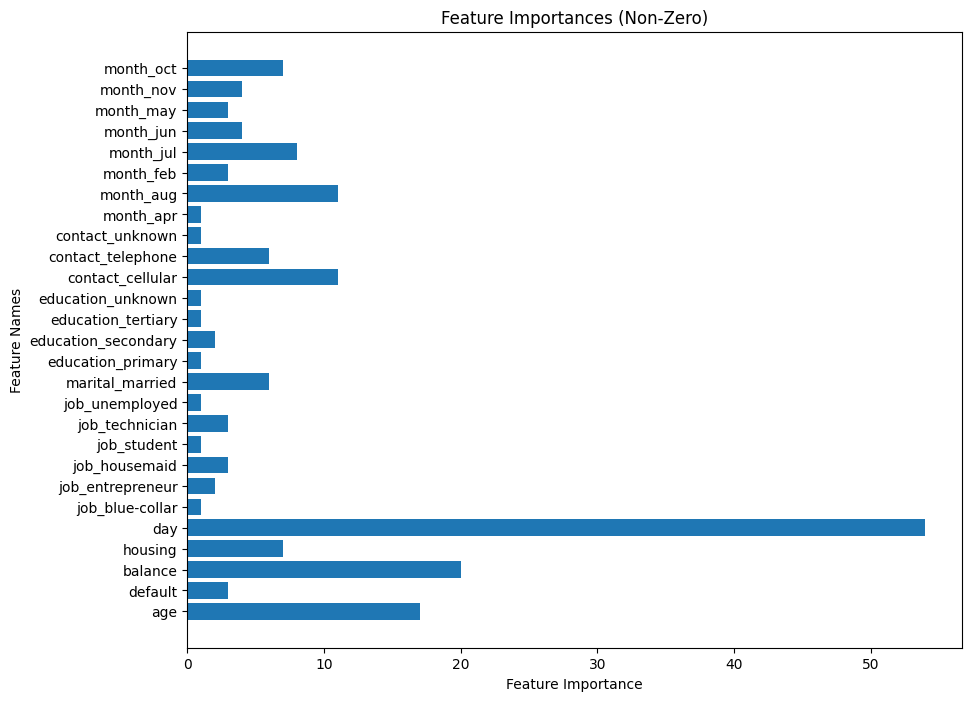

In [ ]:
# Get the feature names and their importance values
feature_names = automl_e.model.feature_name_
feature_importances = automl_e.model.feature_importances_

# Filter the features with non-zero importance values
non_zero_features = [(name, importance) for name, importance in zip(feature_names, feature_importances) if importance != 0]

# Unzip the filtered features and their importance values
filtered_feature_names, filtered_feature_importances = zip(*non_zero_features)

# Plot the filtered features
plt.figure(figsize=(10, 8))
plt.barh(filtered_feature_names, filtered_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importances (Non-Zero)')
plt.show()

In [ ]:
def custom_scoring_metric(real_value, predicted_value):
    if real_value - 3 <= predicted_value <= real_value + 2:
        return 1
    elif predicted_value > real_value + 2:
        return -1
    else:
        return 0

# Example usage
real_value = 10
predicted_value = 12
score = custom_scoring_metric(y_test, y_predict)
print(f"Score: {score}")

In [ ]:
def custom_scoring_metric(real_value, predicted_value):
    if real_value - 3 <= predicted_value <= real_value + 2:
        return 1
    elif predicted_value > real_value + 2:
        return -1
    else:
        return 0

# Example usage
real_value = 10
predicted_value = 12
score = custom_scoring_metric(y_test, y_predict_e)
print(f"Score: {score}")